
# **COVID-19 Data Analysis Project**
---


`Team:  Hossein, Keerthi, Sathiya, Siva, Tejo`

## Overview

This notebook presents a comprehensive analysis of COVID-19 data to uncover key trends, forecast future case numbers, and provide insights into the pandemic's impact globally. Our aim is to leverage data-driven approaches to better understand the spread and implications of COVID-19, aiding in informed decision-making for healthcare and policy planning.

## Scope of Analysis

- **Data Exploration**: Conduct exploratory data analysis (EDA) to understand the dataset's characteristics and uncover initial patterns.
- **Trend Analysis**: Analyze trends in COVID-19 cases and deaths over time and across different geographical regions.
- **Predictive Modeling**: Build and evaluate predictive models to forecast the future trajectory of the pandemic.
- **Impact Assessment**: Assess the impact of various factors such as vaccination rates, public health policies, and demographic variables on COVID-19 trends.


## Data Sources

Our analysis utilizes data from the following sources:

- [Johns Hopkins University COVID-19 Data Repository](https://github.com/CSSEGISandData/COVID-19): Provides daily updates on COVID-19 cases and deaths worldwide.
- [Our World in Data COVID-19 Dataset](https://ourworldindata.org/coronavirus): Offers extensive data on COVID-19 vaccinations, testing, and other relevant metrics.

## Methodologies Used

- **Data Cleaning and Preprocessing**: Standardizing data formats, handling missing values, and data normalization.
- **Statistical Analysis and Visualization**: Using statistical methods and visualization tools to interpret data trends and patterns.
- **Machine Learning**: Implementing models like SARIMA, Random Forest, and Neural Networks for time series forecasting.
- **MLflow for Experiment Tracking**: Utilizing MLflow to track experiments, log model parameters, and evaluate model performance.

# ***Setup - Installs and Imports***

In [ ]:
!pip install mlflow --quiet
!pip install pyngrok --quiet
!pip install pmdarima
!pip install joblib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.6/230.6 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import joblib
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import requests
import geopandas as gpd
import mlflow
import mlflow.keras
from pyngrok import ngrok
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import r2_score
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_absolute_error
from pmdarima import auto_arima

# ***Data Extraction & Cleaning***

In [ ]:
# Function to generate dates in the desired range
def generate_dates(start_date, end_date):
    current_date = datetime.strptime(start_date, '%m-%d-%Y')
    end_date = datetime.strptime(end_date, '%m-%d-%Y')
    while current_date <= end_date:
        yield current_date.strftime('%m-%d-%Y')
        current_date += timedelta(days=1)

# Generate list of filenames
start_date = '05-01-2021'
end_date = '09-30-2022'
filenames = [f"{date}.csv" for date in generate_dates(start_date, end_date)]

base_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us/"

dataframes = []
for filename in filenames:
    try:
        df = pd.read_csv(base_url + filename)
        dataframes.append(df)
    except FileNotFoundError:
        print(f"File not found: {filename}")

# Concatenate all dataframes
combined_df = pd.concat(dataframes)

combined_df['Date'] = pd.to_datetime(combined_df['Date'])
combined_df.sort_values(by='Date', inplace=True)

In [ ]:
# Count nulls in the 'Date' column
null_count = combined_df['Date'].isna().sum()
print(f"Number of nulls in Date column in JHU data: {null_count}")

Number of nulls in Date column in JHU data: 580


In [ ]:
combined_df.reset_index(drop=True, inplace=True)

# Convert Last_Updated_Time to datetime
combined_df['Last_Update'] = pd.to_datetime(combined_df['Last_Update'])

# Update Date where it's Naand Last_Updated_Time is not empty
combined_df.loc[combined_df['Date'].isna() & combined_df['Last_Update'].notna(), 'Date'] = combined_df['Last_Update'].dt.date - pd.Timedelta(days=1)

In [ ]:
combined_df.tail(n=10)

Province_State Country_Region         Last_Update      Lat     Long_  \
30034       Tennessee             US 2022-10-01 04:31:49  35.7478  -86.6923   
30035           Texas             US 2022-10-01 04:31:49  31.0545  -97.5635   
30036            Utah             US 2022-10-01 04:31:49  40.1500 -111.8624   
30037         Vermont             US 2022-10-01 04:31:49  44.0459  -72.7107   
30038  Virgin Islands             US 2022-10-01 04:31:49  18.3358  -64.8963   
30039        Virginia             US 2022-10-01 04:31:49  37.7693  -78.1700   
30040      Washington             US 2022-10-01 04:31:49  47.4009 -121.4905   
30041   West Virginia             US 2022-10-01 04:31:49  38.4912  -80.9545   
30042       Wisconsin             US 2022-10-01 04:31:49  44.2685  -89.6165   
30043         Wyoming             US 2022-10-01 04:31:49  42.7560 -107.3025   

       Confirmed  Deaths  Recovered  Active  FIPS  ...  Total_Test_Results  \
30034    2340561   27871        NaN     NaN  47.0  ...                 NaN   
30035    7967713   90609        NaN     NaN  48.0  ...                 NaN   
30036    1038416    5021        NaN     NaN  49.0  ...                 NaN   
30037     142443     719        NaN     NaN  50.0  ...                 NaN   
30038      23166     123        NaN     NaN  78.0  ...                 NaN   
30039    2087360   21849        NaN     NaN  51.0  ...                 NaN   
30040    1816183   14339        NaN     NaN  53.0  ...                 NaN   
30041     600558    7416        NaN     NaN  54.0  ...                 NaN   
30042    1866634   15263        NaN     NaN  55.0  ...                 NaN   
30043     176728    1894        NaN     NaN  56.0  ...                 NaN   

       People_Hospitalized  Case_Fatality_Ratio         UID  ISO3  \
30034                  NaN             1.189410  84000047.0   USA   
30035                  NaN             1.136947  84000048.0   USA   
30036                  NaN             0.483525  84000049.0   USA   
30037                  NaN             0.504763  84000050.0   USA   
30038                  NaN             0.530951       850.0   VIR   
30039                  NaN             1.046729  84000051.0   USA   
30040                  NaN             0.789513  84000053.0   USA   
30041                  NaN             1.234852  84000054.0   USA   
30042                  NaN             0.817675  84000055.0   USA   
30043                  NaN             1.071703  84000056.0   USA   

      Testing_Rate  Hospitalization_Rate       Date People_Tested  \
30034          NaN                   NaN 2022-09-30           NaN   
30035          NaN                   NaN 2022-09-30           NaN   
30036          NaN                   NaN 2022-09-30           NaN   
30037          NaN                   NaN 2022-09-30           NaN   
30038          NaN                   NaN 2022-09-30           NaN   
30039          NaN                   NaN 2022-09-30           NaN   
30040          NaN                   NaN 2022-09-30           NaN   
30041          NaN                   NaN 2022-09-30           NaN   
30042          NaN                   NaN 2022-09-30           NaN   
30043          NaN                   NaN 2022-09-30           NaN   

       Mortality_Rate  
30034             NaN  
30035             NaN  
30036             NaN  
30037             NaN  
30038             NaN  
30039             NaN  
30040             NaN  
30041             NaN  
30042             NaN  
30043             NaN  

[10 rows x 21 columns]

In [ ]:
# Calculating daily deaths by state
combined_df['Daily_Deaths'] = combined_df.groupby('Province_State')['Deaths'].diff().fillna(0)

# Calculating daily cases by state
combined_df['Daily_ConfirmedCases'] = combined_df.groupby('Province_State')['Confirmed'].diff().fillna(0)

In [ ]:
# Replacing the original 'Deaths' column with these values
combined_df['Deaths'] = combined_df['Daily_Deaths']
del combined_df['Daily_Deaths']

# Replacing the original 'confirmed' column with these values
combined_df['Confirmed'] = combined_df['Daily_ConfirmedCases']
del combined_df['Daily_ConfirmedCases']

In [ ]:
# Counting the number of rows where Deaths and Cases is negative
negative_cases_count = (combined_df['Confirmed'] < 0).sum()
negative_deaths_count = (combined_df['Deaths'] < 0).sum()

print(f"Number of rows with negative deaths: {negative_deaths_count}")
print(f"Number of rows with negative cases: {negative_cases_count}")

Number of rows with negative deaths: 172
Number of rows with negative cases: 67


In [ ]:
combined_df['Deaths'] = combined_df['Deaths'].clip(lower=0)

combined_df['Confirmed'] = combined_df['Confirmed'].clip(lower=0)

In [ ]:
# Removing rows where Province_State is not right
combined_df = combined_df[~combined_df['Province_State'].isin(['Grand Princess', 'Diamond Princess'])]

In [ ]:
combined_df['FIPS'] = pd.to_numeric(combined_df['FIPS'], errors='coerce').fillna(0).astype(int).astype(str)

combined_df['Deaths'] = pd.to_numeric(combined_df['Deaths'], errors='coerce').fillna(0).astype(int)

combined_df['Confirmed'] = pd.to_numeric(combined_df['Confirmed'], errors='coerce').fillna(0).astype(int)

In [ ]:
combined_df = combined_df[['Deaths', 'Confirmed', 'Province_State', 'Date', 'FIPS', 'Lat', 'Long_']]

combined_df.to_csv('StateWiseDeaths.csv', index=False)

In [ ]:
combined_df.loc[combined_df['Province_State']=='California']

Deaths  Confirmed Province_State       Date FIPS      Lat     Long_
35          0          0     California 2021-05-01    6  36.1162 -119.6816
92         45       1634     California 2021-05-02    6  36.1162 -119.6816
153         2       1477     California 2021-05-03    6  36.1162 -119.6816
209        51       1626     California 2021-05-04    6  36.1162 -119.6816
268        58       1574     California 2021-05-05    6  36.1162 -119.6816
...       ...        ...            ...        ...  ...      ...       ...
29759      33       3525     California 2022-09-26    6  36.1162 -119.6816
29817      11      16645     California 2022-09-27    6  36.1162 -119.6816
29875      26       1588     California 2022-09-28    6  36.1162 -119.6816
29933     154       7675     California 2022-09-29    6  36.1162 -119.6816
29991       0       2944     California 2022-09-30    6  36.1162 -119.6816

[518 rows x 7 columns]

In [ ]:
cdc_data_df = pd.read_csv('cdc_updated_data.csv')

In [ ]:
cdc_data_df.loc[cdc_data_df['Recip_State']=='CA']

Date   FIPS Recip_State          Recip_County  \
19      2021-05-02  06103          CA         Tehama County   
43      2021-05-02  06067          CA     Sacramento County   
78      2021-05-02  06077          CA    San Joaquin County   
126     2021-05-02  06021          CA          Glenn County   
156     2021-05-02  06085          CA    Santa Clara County   
...            ...    ...         ...                   ...   
1398201 2022-09-28  06083          CA  Santa Barbara County   
1398268 2022-09-28  06037          CA    Los Angeles County   
1398290 2022-09-28  06069          CA     San Benito County   
1398303 2022-09-28  06045          CA      Mendocino County   
1398432 2022-09-28  06107          CA         Tulare County   

         Booster_Doses_18Plus  Series_Complete_18Plus  \
19                        0.0                 13283.0   
43                        0.0                457250.0   
78                        0.0                179401.0   
126                       0.0                  7714.0   
156                       0.0                691295.0   
...                       ...                     ...   
1398201              170665.0                286022.0   
1398268             3906059.0               6475016.0   
1398290               22595.0                 36566.0   
1398303               30113.0                 54392.0   
1398432              111607.0                223082.0   

         Administered_Dose1_Recip_18Plus  Census2019_18PlusPop  \
19                               16916.0               49621.0   
43                              615601.0             1188937.0   
78                              301204.0              557577.0   
126                               9481.0               20833.0   
156                            1106708.0             1511937.0   
...                                  ...                   ...   
1398201                         317665.0              347943.0   
1398268                        7245290.0             7894557.0   
1398290                          39948.0               46822.0   
1398303                          60777.0               68430.0   
1398432                         249831.0              324089.0   

         Series_Complete_65Plus  Administered_Dose1_Recip_65Plus State_FIPS  \
19                       5991.0                           7150.0         06   
43                     155927.0                         175500.0         06   
78                      64396.0                          88305.0         06   
126                      3082.0                           3540.0         06   
156                    205595.0                         235544.0         06   
...                         ...                              ...        ...   
1398201                 66014.0                          72467.0         06   
1398268               1241861.0                        1373112.0         06   
1398290                  7259.0                           7946.0         06   
1398303                 17660.0                          19297.0         06   
1398432                 45239.0                          50034.0         06   

         Administered_Doses_18Plus_Daily  Series_Complete_18Plus_Daily  \
19                                   0.0                           0.0   
43                                   0.0                           0.0   
78                                   0.0                           0.0   
126                                  0.0                           0.0   
156                                  0.0                           0.0   
...                                  ...                           ...   
1398201                            352.0                         214.0   
1398268                           7481.0                        5113.0   
1398290                             58.0                          20.0   
1398303                             77.0                          52.0   
1398432         

In [ ]:
cdc_data_df['Date'] = pd.to_datetime(cdc_data_df['Date'])

print(cdc_data_df['Date'].min())
print(cdc_data_df['Date'].max())

2021-05-02 00:00:00
2022-09-28 00:00:00


In [ ]:
cdc_data_df.Date.unique()

array(['2021-05-02T00:00:00.000000000', '2021-05-03T00:00:00.000000000',
       '2021-05-04T00:00:00.000000000', '2021-05-05T00:00:00.000000000',
       '2021-05-06T00:00:00.000000000', '2021-05-07T00:00:00.000000000',
       '2021-05-08T00:00:00.000000000', '2021-05-09T00:00:00.000000000',
       '2021-05-10T00:00:00.000000000', '2021-05-11T00:00:00.000000000',
       '2021-05-12T00:00:00.000000000', '2021-05-13T00:00:00.000000000',
       '2021-05-14T00:00:00.000000000', '2021-05-15T00:00:00.000000000',
       '2021-05-16T00:00:00.000000000', '2021-05-17T00:00:00.000000000',
       '2021-05-18T00:00:00.000000000', '2021-05-19T00:00:00.000000000',
       '2021-05-20T00:00:00.000000000', '2021-05-21T00:00:00.000000000',
       '2021-05-22T00:00:00.000000000', '2021-05-23T00:00:00.000000000',
       '2021-05-24T00:00:00.000000000', '2021-05-25T00:00:00.000000000',
       '2021-05-26T00:00:00.000000000', '2021-05-27T00:00:00.000000000',
       '2021-05-28T00:00:00.000000000', '2021-05-29

In [ ]:
cdc_data_df['State_FIPS'] = cdc_data_df['FIPS'].str[:2]

In [ ]:
# Replace NaN values with 0 in all columns
cdc_data_df.fillna(0, inplace=True)

In [ ]:
cdc_data_df['Administered_Doses_18Plus_Daily'] = cdc_data_df.groupby(['State_FIPS', 'FIPS'])['Administered_Dose1_Recip_18Plus'].diff().fillna(0)

cdc_data_df['Series_Complete_18Plus_Daily'] = cdc_data_df.groupby(['State_FIPS', 'FIPS'])['Series_Complete_18Plus'].diff().fillna(0)

cdc_data_df['Booster_Doses_18Plus_Daily'] = cdc_data_df.groupby(['State_FIPS', 'FIPS'])['Booster_Doses_18Plus'].diff().fillna(0)

cdc_data_df['Series_Complete_65Plus_Daily'] = cdc_data_df.groupby(['State_FIPS', 'FIPS'])['Series_Complete_65Plus'].diff().fillna(0)

cdc_data_df['Administered_Doses_65Plus_Daily'] = cdc_data_df.groupby(['State_FIPS', 'FIPS'])['Administered_Dose1_Recip_65Plus'].diff().fillna(0)


In [ ]:
# List of specific columns to update
columns_to_update = ['Administered_Doses_65Plus_Daily', 'Series_Complete_65Plus_Daily', 'Booster_Doses_18Plus_Daily',
                     'Series_Complete_18Plus_Daily', 'Administered_Doses_18Plus_Daily']

# Replacing negative values in specific columns with 0
for col in columns_to_update:
    cdc_data_df[col] = cdc_data_df[col].clip(lower=0)

In [ ]:
# Count nulls in a 'Date' column
null_count = cdc_data_df['Date'].isna().sum()
print(f"Number of nulls in Date column in CDC data: {null_count}")

Number of nulls in Date column in CDC data: 0


In [ ]:
new_df = cdc_data_df.groupby(['Date', 'State_FIPS']).agg({
    'Administered_Doses_65Plus_Daily':'sum',
    'Series_Complete_65Plus_Daily':'sum',
    'Booster_Doses_18Plus_Daily':'sum',
    'Series_Complete_18Plus_Daily':'sum',
    'Administered_Doses_18Plus_Daily':'sum',
    'Census2019_18PlusPop':'sum'
})

In [ ]:
new_df = new_df.reset_index()

In [ ]:
new_df.loc[new_df['State_FIPS']=='06']

Date State_FIPS  Administered_Doses_65Plus_Daily  \
4     2021-05-02         06                              0.0   
59    2021-05-03         06                           3725.0   
114   2021-05-04         06                           1985.0   
169   2021-05-05         06                           5388.0   
224   2021-05-06         06                           9822.0   
...          ...        ...                              ...   
23159 2022-08-31         06                           2837.0   
23214 2022-09-07         06                           1378.0   
23269 2022-09-14         06                           5068.0   
23324 2022-09-21         06                           6879.0   
23379 2022-09-28         06                           9323.0   

       Series_Complete_65Plus_Daily  Booster_Doses_18Plus_Daily  \
4                               0.0                         0.0   
59                           5509.0                         0.0   
114                          2380.0                         0.0   
169                          8000.0                         0.0   
224                         13036.0                         0.0   
...                             ...                         ...   
23159                        2021.0                     25460.0   
23214                        1020.0                      9902.0   
23269                        4101.0                     26553.0   
23324                        5184.0                     41071.0   
23379                        5608.0                     42785.0   

       Series_Complete_18Plus_Daily  Administered_Doses_18Plus_Daily  \
4                               0.0                              0.0   
59                         113037.0                          69157.0   
114                         47620.0                          34221.0   
169                        123578.0                          67868.0   
224                        193923.0                         116752.0   
...                             ...                              ...   
23159                       10859.0                          16253.0   
23214                        5417.0                           7963.0   
23269                       19283.0                          27649.0   
23324                       21080.0                          29489.0   
23379                       21626.0                          36206.0   

       Census2019_18PlusPop  
4                30617582.0  
59               30617582.0  
114              30617582.0  
169              30617582.0  
224              30617582.0  
...                     ...  
23159            30617582.0  
23214            30617582.0  
23269            30617582.0  
23324            30617582.0  
23379            30617582.0  

[426 rows x 8 columns]

In [ ]:
# remove bad data
new_df = new_df[~new_df['State_FIPS'].isin(['78', 'UN'])]

In [ ]:
combined_df['Date'] = pd.to_datetime(combined_df['Date'])

In [ ]:
combined_df['FIPS'] = combined_df['FIPS'].apply(lambda x: x.zfill(2))

In [ ]:
combined_df.FIPS.unique()

array(['01', '31', '32', '33', '34', '35', '36', '37', '38', '69', '39',
       '40', '42', '30', '72', '45', '46', '47', '48', '49', '50', '78',
       '51', '53', '54', '55', '56', '44', '29', '41', '27', '28', '60',
       '04', '05', '06', '08', '09', '10', '11', '12', '13', '02', '15',
       '66', '25', '24', '23', '22', '21', '26', '19', '18', '17', '16',
       '20'], dtype=object)

In [ ]:
# Merge the dataframes on State FIPS and Date
merged_df = pd.merge(new_df, combined_df, left_on=['State_FIPS', 'Date'], right_on=['FIPS', 'Date'])

In [ ]:
merged_df.columns

Index(['Date', 'State_FIPS', 'Administered_Doses_65Plus_Daily',
       'Series_Complete_65Plus_Daily', 'Booster_Doses_18Plus_Daily',
       'Series_Complete_18Plus_Daily', 'Administered_Doses_18Plus_Daily',
       'Census2019_18PlusPop', 'Deaths', 'Confirmed', 'Province_State', 'FIPS',
       'Lat', 'Long_'],
      dtype='object')

In [ ]:
merged_df.to_csv('final_merged_df.csv', index=False)

In [ ]:
merged_df.loc[merged_df['State_FIPS']=='06']

Date State_FIPS  Administered_Doses_65Plus_Daily  \
4     2021-05-02         06                              0.0   
57    2021-05-03         06                           3725.0   
110   2021-05-04         06                           1985.0   
163   2021-05-05         06                           5388.0   
216   2021-05-06         06                           9822.0   
...          ...        ...                              ...   
22317 2022-08-31         06                           2837.0   
22370 2022-09-07         06                           1378.0   
22423 2022-09-14         06                           5068.0   
22476 2022-09-21         06                           6879.0   
22529 2022-09-28         06                           9323.0   

       Series_Complete_65Plus_Daily  Booster_Doses_18Plus_Daily  \
4                               0.0                         0.0   
57                           5509.0                         0.0   
110                          2380.0                         0.0   
163                          8000.0                         0.0   
216                         13036.0                         0.0   
...                             ...                         ...   
22317                        2021.0                     25460.0   
22370                        1020.0                      9902.0   
22423                        4101.0                     26553.0   
22476                        5184.0                     41071.0   
22529                        5608.0                     42785.0   

       Series_Complete_18Plus_Daily  Administered_Doses_18Plus_Daily  \
4                               0.0                              0.0   
57                         113037.0                          69157.0   
110                         47620.0                          34221.0   
163                        123578.0                          67868.0   
216                        193923.0                         116752.0   
...                             ...                              ...   
22317                       10859.0                          16253.0   
22370                        5417.0                           7963.0   
22423                       19283.0                          27649.0   
22476                       21080.0                          29489.0   
22529                       21626.0                          36206.0   

       Census2019_18PlusPop  Deaths  Confirmed Province_State FIPS      Lat  \
4                30617582.0      45       1634     California   06  36.1162   
57               30617582.0       2       1477     California   06  36.1162   
110              30617582.0      51       1626     California   06  36.1162   
163              30617582.0      58       1574     California   06  36.1162   
216              30617582.0      84       2789     California   06  36.1162   
...                     ...     ...        ...            ...  ...      ...   
22317            30617582.0      21       3878     California   06  36.1162   
22370            30617582.0      18       2272     California   06  36.1162   
22423            30617582.0      41       2075     California   06  36.1162   
22476            30617582.0      31       1683     California   06  36.1162   
22529            30617582.0      26       1588     California   06  36.1162   

          Long_  
4     -119.6816  
57    -119.6816  
110   -119.6816  
163   -119.6816  
216   -119.6816  
...         ...  
22317 -119.6816  
22370 -119.6816  
22423 -119.6816  
22476 -119.6816  
22529 -119.6816  

[426 rows x 14 columns]

In [ ]:
merged_df

Date State_FIPS  Administered_Doses_65Plus_Daily  \
0     2021-05-02         01                              0.0   
1     2021-05-02         02                              0.0   
2     2021-05-02         04                              0.0   
3     2021-05-02         05                              0.0   
4     2021-05-02         06                              0.0   
...          ...        ...                              ...   
22573 2022-09-28         54                            433.0   
22574 2022-09-28         55                           1023.0   
22575 2022-09-28         56                            161.0   
22576 2022-09-28         66                              0.0   
22577 2022-09-28         72                            806.0   

       Series_Complete_65Plus_Daily  Booster_Doses_18Plus_Daily  \
0                               0.0                         0.0   
1                               0.0                         0.0   
2                               0.0                         0.0   
3                               0.0                         0.0   
4                               0.0                         0.0   
...                             ...                         ...   
22573                         405.0                      1515.0   
22574                        1056.0                      5030.0   
22575                         127.0                       428.0   
22576                           3.0                         5.0   
22577                        1458.0                      8215.0   

       Series_Complete_18Plus_Daily  Administered_Doses_18Plus_Daily  \
0                               0.0                              0.0   
1                               0.0                              0.0   
2                               0.0                              0.0   
3                               0.0                              0.0   
4                               0.0                              0.0   
...                             ...                              ...   
22573                         914.0                           1083.0   
22574                        3367.0                           3835.0   
22575                         272.0                            407.0   
22576                           8.0                              0.0   
22577                        5671.0                           3690.0   

       Census2019_18PlusPop  Deaths  Confirmed Province_State FIPS      Lat  \
0                 3814879.0       0        288        Alabama   01  32.3182   
1                  551562.0       0          0         Alaska   02  61.3707   
2                 5638481.0       6        356        Arizona   04  33.7298   
3                 2317649.0       2        137       Arkansas   05  34.9697   
4                30617582.0      45       1634     California   06  36.1162   
...                     ...     ...        ...            ...  ...      ...   
22573             1432580.0       4        334  West Virginia   54  38.4912   
22574             4555837.0      17       1193      Wisconsin   55  44.2685   
22575              445025.0       0          0        Wyoming   56  42.7560   
22576              114544.0       0         38           Guam   66  13.4443   
22577             2620963.0       4        624    Puerto Rico   72  18.2208   

          Long_  
0      -86.9023  
1     -152.4044  
2     -111.4312  
3      -92.3731  
4     -119.6816  
...         ...  
22573  -80.9545  
22574  -89.6165  
22575 -107.3025  
22576  144.7937  
22577  -66.5901  

[22578 rows x 14 columns]

# ***EDA & Viz***




The markdowns below were listed to indicate the cases, vaccine administration, and deaths of various locations and timeframes.

1. Bubble chart - Filtering out the top 10 states affected, plot the relationship between administered doses, completed vaccine series, and deaths.

In [ ]:
df1 = pd.read_csv('final_merged_df.csv')

In [ ]:
df1.columns

Index(['Date', 'State_FIPS', 'Administered_Doses_65Plus_Daily',
       'Series_Complete_65Plus_Daily', 'Booster_Doses_18Plus_Daily',
       'Series_Complete_18Plus_Daily', 'Administered_Doses_18Plus_Daily',
       'Census2019_18PlusPop', 'Deaths', 'Confirmed', 'Province_State', 'FIPS',
       'Lat', 'Long_'],
      dtype='object')

In [ ]:
top_10_states = df1.groupby('Province_State')['Series_Complete_18Plus_Daily'].sum().nlargest(10).index

In [ ]:
top_10_states

Index(['Texas', 'California', 'Florida', 'New York', 'Pennsylvania',
       'Illinois', 'Georgia', 'Colorado', 'Virginia', 'Ohio'],
      dtype='object', name='Province_State')

In [ ]:
top_10_states_data = df1[df1['Province_State'].isin(top_10_states)]

In [ ]:
top_10_states_data

Date  State_FIPS  Administered_Doses_65Plus_Daily  \
4      2021-05-02           6                              0.0   
5      2021-05-02           8                              0.0   
9      2021-05-02          12                              0.0   
10     2021-05-02          13                              0.0   
13     2021-05-02          17                              0.0   
...           ...         ...                              ...   
22557  2022-09-28          36                           4112.0   
22560  2022-09-28          39                           1532.0   
22563  2022-09-28          42                           1767.0   
22568  2022-09-28          48                           2343.0   
22571  2022-09-28          51                           1006.0   

       Series_Complete_65Plus_Daily  Booster_Doses_18Plus_Daily  \
4                               0.0                         0.0   
5                               0.0                         0.0   
9                               0.0                         0.0   
10                              0.0                         0.0   
13                              0.0                         0.0   
...                             ...                         ...   
22557                        6272.0                     25494.0   
22560                        1449.0                      8051.0   
22563                        1222.0                      2473.0   
22568                        2365.0                     14535.0   
22571                        1097.0                      5444.0   

       Series_Complete_18Plus_Daily  Administered_Doses_18Plus_Daily  \
4                               0.0                              0.0   
5                               0.0                              0.0   
9                               0.0                              0.0   
10                              0.0                              0.0   
13                              0.0                              0.0   
...                             ...                              ...   
22557                       23776.0                          17323.0   
22560                        4460.0                           5501.0   
22563                        3845.0                           5647.0   
22568                        9434.0                          13554.0   
22571                        4211.0                           4332.0   

       Census2019_18PlusPop  Deaths  Confirmed Province_State  FIPS      Lat  \
4                30617582.0      45       1634     California     6  36.1162   
5                 4499217.0       3       1001       Colorado     8  39.0598   
9                17247808.0      29       3841        Florida    12  27.7663   
10                8113542.0       0       1302        Georgia    13  33.0406   
13                9853946.0      28       1860       Illinois    17  40.3495   
...                     ...     ...        ...            ...   ...      ...   
22557            15425262.0      26       4307       New York    36  42.1657   
22560             9111081.0      15          0           Ohio    39  40.3888   
22563            10167376.0     115      14210   Pennsylvania    42  40.5908   
22568            21596071.0       4        675          Texas    48  31.0545   
22571             6674671.0      23       1452       Virginia    51  37.7693   

          Long_  
4     -119.6816  
5     -105.3111  
9      -81.6868  
10     -83.6431  
13     -88.9861  
...         ...  
22557  -74.9481  
22560  -82.7649  
22563  -77.2098  
22568  -97.5635  
22571  -78.1700  

[4260 rows x 14 columns]

In [ ]:
bubble_chart_data_top_10 = top_10_states_data.groupby('Province_State').agg({
    'Administered_Doses_18Plus_Daily': 'sum',
    'Series_Complete_18Plus_Daily': 'sum',
    'Deaths': 'sum',
    'Census2019_18PlusPop': 'mean'
}).reset_index()

In [ ]:
fig = px.scatter(bubble_chart_data_top_10, x='Administered_Doses_18Plus_Daily', y='Series_Complete_18Plus_Daily',
                 size='Census2019_18PlusPop', color='Province_State', hover_name='Province_State',
                 log_x=True, log_y=True, size_max=60,
                 title='Relationship Between Administered Doses, Completed Vaccine Series, and Deaths for Top 10 States',
                 labels={'Administered_Doses_18Plus_Daily': 'Total Administered Doses',
                         'Series_Complete_18Plus_Daily': 'Total Completed Series',
                         'Census2019_18PlusPop': '18+ Population'})
fig.show()

There appears to be a positive correlation between the total administered doses and the total completed vaccine series. States with higher administered doses also tend to have a higher number of completed vaccine series, which is expected as more doses would naturally lead to more people completing the vaccination series.

Larger bubbles in states with more administered doses could indicate higher death tolls, which may reflect larger populations or more severe COVID-19 outbreaks in those states prior to or during the vaccination campaigns.


California and Texas, represented by large bubbles, suggest these states have administered a high number of doses and have large populations, thus possibly a higher number of deaths.
States like New York and Pennsylvania, with moderately sized bubbles, may have fewer deaths or a higher efficiency in vaccine administration relative to their populations.

The graph shows a time-series comparison of COVID-19 administered vaccine doses for adults (18+) against reported deaths over a period ranging from July 2021 to September 2022.

In [ ]:
df1['Date'] = pd.to_datetime(df1['Date'])

# Aggregate data by date for time series analysis
df_grouped_date = df1.groupby('Date').sum().reset_index()

# Creating time series plot with Plotly
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=df_grouped_date['Date'], y=df_grouped_date['Administered_Doses_18Plus_Daily'], name="Administered Doses 18+"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df_grouped_date['Date'], y=df_grouped_date['Deaths'], name="Deaths"),
    secondary_y=True,
)

fig.update_layout(
    title_text="COVID-19 Vaccination (18+) and Deaths Over Time"
)

fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="Administered Doses (18+)", secondary_y=False)
fig.update_yaxes(title_text="Deaths", secondary_y=True)

fig.show()

<ipython-input-12-c833fe5ee98c>:4: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



The blue line representing administered vaccine doses shows fluctuations over time, with peaks suggesting periods of intensified vaccination efforts. These could correlate with vaccine rollouts, booster campaigns, or responses to rising cases.

The red line indicating deaths shows variability as well, with what appears to be a decline over time, albeit with some periodic spikes. These spikes may align with waves of COVID-19 cases or variants, which typically lead to increased deaths with a lagging effect after case surges.

Initially, there doesn't seem to be a direct inverse correlation visible in the graph between vaccine doses administered and deaths; however, a general trend suggests that as vaccine administration increased, deaths plateaued or decreased. This would be consistent with the understanding that vaccines reduce the severity of COVID-19 outcomes, leading to fewer deaths.

Towards the later dates in the graph, despite fluctuations in vaccine administration, the death counts seem to show a gradual decline, possibly indicating the long-term benefits of vaccination in reducing COVID-19 mortality.

In [ ]:
eda_df = df1.copy()

# Total administered doses divided by the adult population (18+)
eda_df['Vaccination_Rate'] = eda_df['Administered_Doses_18Plus_Daily'] / eda_df['Census2019_18PlusPop']

# Total deaths divided by the adult population (18+)
eda_df['Death_Rate'] = eda_df['Deaths'] / eda_df['Census2019_18PlusPop']

# Top 10 states by vaccination rate
top_10_vaccination_states = eda_df.sort_values(by='Vaccination_Rate', ascending=False).head(10)

# Bottom 10 states by death rate
bottom_10_death_states = eda_df.sort_values(by='Death_Rate').head(10)

# Combining the top 10 vaccination states and bottom 10 death states for the scatter plot
selected_states = pd.concat([top_10_vaccination_states, bottom_10_death_states]).drop_duplicates()

# Displaying the lists of top 10 and bottom 10 states
top_10_vaccination_states_list = top_10_vaccination_states['Province_State'].tolist()
bottom_10_death_states_list = bottom_10_death_states['Province_State'].tolist()

top_10_vaccination_states_list, bottom_10_death_states_list

(['Rhode Island',
  'Texas',
  'New Mexico',
  'New Hampshire',
  'South Dakota',
  'Colorado',
  'Ohio',
  'Nebraska',
  'Colorado',
  'Michigan'],
 ['Alabama',
  'Michigan',
  'Minnesota',
  'Mississippi',
  'Missouri',
  'Montana',
  'Nebraska',
  'Nebraska',
  'Nevada',
  'New Hampshire'])

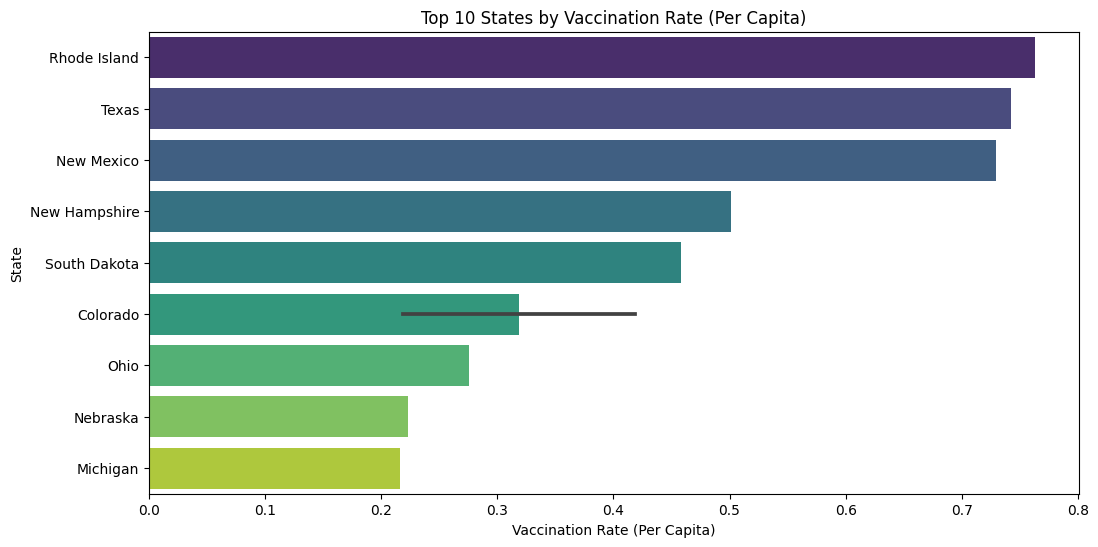

In [ ]:
# Identifying the top 10 states by vaccination rate
# top_10_vaccination_states = df.sort_values(by='Vaccination_Rate', ascending=False).head(10)

# Horizontal bar chart for the top 10 states by vaccination rate
plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_vaccination_states, x='Vaccination_Rate', y='Province_State', palette='viridis')
plt.title('Top 10 States by Vaccination Rate (Per Capita)')
plt.xlabel('Vaccination Rate (Per Capita)')
plt.ylabel('State')
plt.show()

The states with the highest vaccination rate per capita were listed here. You'll notice that Texas, Georgia, and New Mexico were the highest by a large margin, each going over 0.7.
Below is a plot indicating the cumulative vaccinations administered over time. Namely, you'll notice each state has large spikes in the data that indicates a day with a large number of vaccinations taking place. However, a trend is noticeable with most states where they will slowly decrease in slope over time as less vaccines are getting administered.


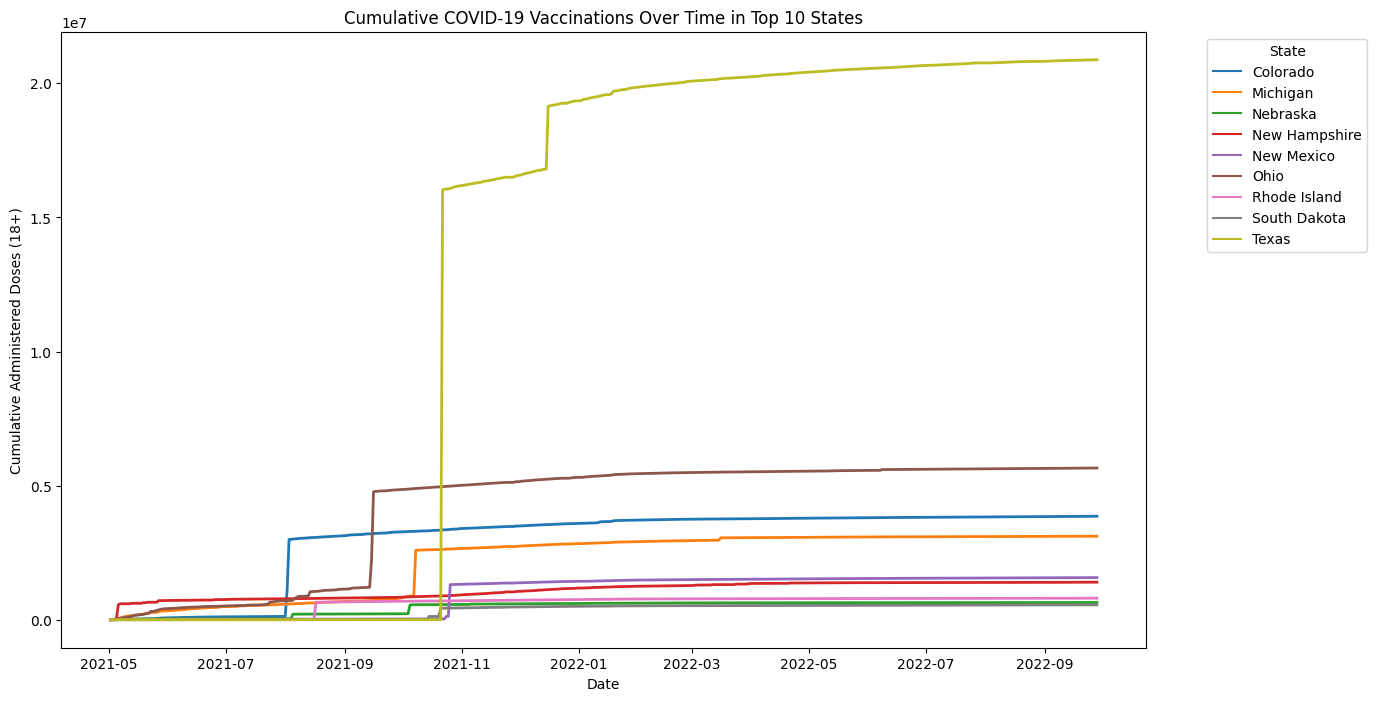

In [ ]:
# Filtering the dataset for the top 10 states
top_states_data = eda_df[eda_df['Province_State'].isin(top_10_vaccination_states['Province_State'])]

# Calculating cumulative doses for each state over time
top_states_cumulative = top_states_data.groupby(['Date', 'Province_State']).sum().groupby('Province_State').cumsum().reset_index()

# Line plot for cumulative doses over time in top 10 states
plt.figure(figsize=(14, 8))
sns.lineplot(data=top_states_cumulative, x='Date', y='Administered_Doses_18Plus_Daily', hue='Province_State', palette='tab10', lw=2)
plt.title('Cumulative COVID-19 Vaccinations Over Time in Top 10 States')
plt.xlabel('Date')
plt.ylabel('Cumulative Administered Doses (18+)')
plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [ ]:
eda_df['Date'] = pd.to_datetime(eda_df['Date'])

# Aggregating data at the national level for each day
daily_national = eda_df.groupby('Date').sum()

# Calculating 7-day rolling averages for vaccinations and deaths
daily_national['Rolling_Avg_Vaccinations'] = daily_national['Series_Complete_18Plus_Daily'].rolling(window=21).mean()
daily_national['Rolling_Avg_Deaths'] = daily_national['Deaths'].rolling(window=21).mean()

# Creating a figure with a secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Adding vaccination data to the primary y-axis
fig.add_trace(
    go.Scatter(x=daily_national.index, y=daily_national['Rolling_Avg_Vaccinations'],
               mode='lines', name='21-Day Avg Vaccinations'),
    secondary_y=False,
)

# Adding death data to the secondary y-axis
fig.add_trace(
    go.Scatter(x=daily_national.index, y=daily_national['Rolling_Avg_Deaths'],
               mode='lines', name='21-Day Avg Deaths', line=dict(color='red')),
    secondary_y=True,
)

fig.update_layout(
    title='21-Day Rolling Average of COVID-19 Vaccinations and Deaths',
    xaxis_title='Date',
    template='plotly_dark'
)

fig.update_yaxes(title_text="Vaccinations (21-Day Avg)", secondary_y=False)
fig.update_yaxes(title_text="Deaths (21-Day Avg)", secondary_y=True)

fig.show()

<ipython-input-16-bf6fc897186d>:4: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [ ]:

statewise_daily = eda_df.groupby(['Date', 'Province_State', 'FIPS', 'Lat', 'Long_']).sum().reset_index()
statewise_daily['Date'] = statewise_daily['Date'].dt.strftime('%Y-%m-%d')

# Creating an interactive map using Plotly
fig = px.scatter_geo(statewise_daily,
                     lat='Lat', lon='Long_',
                     color='Series_Complete_18Plus_Daily',
                     size='Deaths',
                     hover_name='Province_State',
                     animation_frame='Date',
                     scope='usa',
                     title='Daily Statewise COVID-19 Vaccination and Deaths (Interactive Map)',
                     size_max=30)

# Updating layout
fig.update_layout(template='plotly_dark')

# Due to the limitations of this environment, the map might not render here
# You can run this code in your local Python environment to generate the interactive map
fig.show()

This interactive map shows the daily count of administered doses as well as deaths in each state. From scrolling through the dates, you'll see there are dates that range from 0-25k doeses administered across the US (especially after January 2022) and also 0-2.5 million (see 09/16/2021)

In [ ]:
mdf  = pd.read_csv("final_merged_df.csv")

In [ ]:
mdf.head()

Date  State_FIPS  Administered_Doses_65Plus_Daily  \
0  2021-05-02           1                              0.0   
1  2021-05-02           2                              0.0   
2  2021-05-02           4                              0.0   
3  2021-05-02           5                              0.0   
4  2021-05-02           6                              0.0   

   Series_Complete_65Plus_Daily  Booster_Doses_18Plus_Daily  \
0                           0.0                         0.0   
1                           0.0                         0.0   
2                           0.0                         0.0   
3                           0.0                         0.0   
4                           0.0                         0.0   

   Series_Complete_18Plus_Daily  Administered_Doses_18Plus_Daily  \
0                           0.0                              0.0   
1                           0.0                              0.0   
2                           0.0                              0.0   
3                           0.0                              0.0   
4                           0.0                              0.0   

   Census2019_18PlusPop  Deaths  Confirmed Province_State  FIPS      Lat  \
0             3814879.0       0        288        Alabama     1  32.3182   
1              551562.0       0          0         Alaska     2  61.3707   
2             5638481.0       6        356        Arizona     4  33.7298   
3             2317649.0       2        137       Arkansas     5  34.9697   
4            30617582.0      45       1634     California     6  36.1162   

      Long_  
0  -86.9023  
1 -152.4044  
2 -111.4312  
3  -92.3731  
4 -119.6816

In [ ]:
#group by state's total deaths
total_deaths_per_state = mdf.groupby("Province_State", as_index=False)["Deaths"].sum()

#top ten states with most deaths
top_10_most_deaths = total_deaths_per_state.nlargest(10, "Deaths")

#top ten least deaths
top_10_least_deaths = total_deaths_per_state.nsmallest(10, "Deaths")

print("Top 10 states with the most deaths:")
print(top_10_most_deaths[["Province_State", "Deaths"]])

print("\nTop 10 states with the least deaths:")
print(top_10_least_deaths[["Province_State", "Deaths"]])

Top 10 states with the most deaths:
   Province_State  Deaths
9         Florida   40873
45          Texas   38564
4      California   31667
39   Pennsylvania   20846
10        Georgia   20076
36           Ohio   19263
23       Michigan   17984
33       New York   17808
44      Tennessee   14824
14       Illinois   14416

Top 10 states with the least deaths:
          Province_State  Deaths
8   District of Columbia     251
11                  Guam     253
47               Vermont     472
35          North Dakota     817
41          Rhode Island     933
1                 Alaska    1018
43          South Dakota    1055
52               Wyoming    1117
12                Hawaii    1203
30         New Hampshire    1295


Both the Top Ten States with the most and least reported COVID deaths were mapped here. The line plot indicates the cumulative death count for each state. The sharp spikes indicate dates where COVID deaths peaked on a given day, while flatlines were days with zero deaths reported.

In [ ]:
mdf["Sum_Deaths"] = mdf.groupby(["Province_State"])["Deaths"].transform("sum")

dw = mdf[mdf['Province_State'] == 'Delaware']
dw

Date  State_FIPS  Administered_Doses_65Plus_Daily  \
7      2021-05-02          10                              0.0   
60     2021-05-03          10                            116.0   
113    2021-05-04          10                            136.0   
166    2021-05-05          10                            329.0   
219    2021-05-06          10                              6.0   
...           ...         ...                              ...   
22320  2022-08-31          10                            104.0   
22373  2022-09-07          10                             58.0   
22426  2022-09-14          10                             96.0   
22479  2022-09-21          10                            688.0   
22532  2022-09-28          10                            532.0   

       Series_Complete_65Plus_Daily  Booster_Doses_18Plus_Daily  \
7                               0.0                         0.0   
60                            147.0                         0.0   
113                           195.0                         0.0   
166                           535.0                         0.0   
219                             8.0                         0.0   
...                             ...                         ...   
22320                         107.0                       577.0   
22373                          58.0                       342.0   
22426                          37.0                        73.0   
22479                         608.0                      2112.0   
22532                         458.0                      1725.0   

       Series_Complete_18Plus_Daily  Administered_Doses_18Plus_Daily  \
7                               0.0                              0.0   
60                           1184.0                           1030.0   
113                          2305.0                           1185.0   
166                          4538.0                           2437.0   
219                           143.0                            137.0   
...                             ...                              ...   
22320                         419.0                            443.0   
22373                         192.0                            239.0   
22426                          90.0                            212.0   
22479                        1635.0                           1826.0   
22532                        1210.0                           1394.0   

       Census2019_18PlusPop  Deaths  Confirmed Province_State  FIPS      Lat  \
7                  770192.0       0        288       Delaware    10  39.3185   
60                 770192.0       0        158       Delaware    10  39.3185   
113                770192.0       0        137       Delaware    10  39.3185   
166                770192.0       2        197       Delaware    10  39.3185   
219                770192.0       1        171       Delaware    10  39.3185   
...                     ...     ...        ...            ...   ...      ...   
22320              770192.0       0        216       Delaware    10  39.3185   
22373              770192.0       2        145       Delaware    10  39.3185   
22426              770192.0       0        175       Delaware    10  39.3185   
22479              770192.0       2        216       Delaware    10  39.3185   
22532              770192.0       0        215       Delaware    10  39.3185   

         Long_  Sum_Deaths  
7     -75.5071        1352  
60    -75.5071        1352  
113   -75.5071        1352  
166   -75.5071        1352  
219   -75.5071        1352  
...        ...         ...  
22320 -75.5071        1352  
22373 -75.5071        1352  
22426 -75.5071        1352  
22479 -75.5071        1352  
22532 -75.5071        1352  

[426 rows x 15 columns]

In [ ]:
response = requests.get("https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json")
geojson_string = response.text
gdf = gpd.read_file(geojson_string)
gdf

id                  name    density  \
0   01               Alabama     94.650   
1   02                Alaska      1.264   
2   04               Arizona     57.050   
3   05              Arkansas     56.430   
4   06            California    241.700   
5   08              Colorado     49.330   
6   09           Connecticut    739.100   
7   10              Delaware    464.300   
8   11  District of Columbia  10065.000   
9   12               Florida    353.400   
10  13               Georgia    169.500   
11  15                Hawaii    214.100   
12  16                 Idaho     19.150   
13  17              Illinois    231.500   
14  18               Indiana    181.700   
15  19                  Iowa     54.810   
16  20                Kansas     35.090   
17  21              Kentucky    110.000   
18  22             Louisiana    105.000   
19  23                 Maine     43.040   
20  24              Maryland    596.300   
21  25         Massachusetts    840.200   
22  26              Michigan    173.900   
23  27             Minnesota     67.140   
24  28           Mississippi     63.500   
25  29              Missouri     87.260   
26  30               Montana      6.858   
27  31              Nebraska     23.970   
28  32                Nevada     24.800   
29  33         New Hampshire    147.000   
30  34            New Jersey   1189.000   
31  35            New Mexico     17.160   
32  36              New York    412.300   
33  37        North Carolina    198.200   
34  38          North Dakota      9.916   
35  39                  Ohio    281.900   
36  40              Oklahoma     55.220   
37  41                Oregon     40.330   
38  42          Pennsylvania    284.300   
39  44          Rhode Island   1006.000   
40  45        South Carolina    155.400   
41  46          South Dakota     98.070   
42  47             Tennessee     88.080   
43  48                 Texas     98.070   
44  49                  Utah     34.300   
45  50               Vermont     67.730   
46  51              Virginia    204.500   
47  53            Washington    102.600   
48  54         West Virginia     77.060   
49  55             Wisconsin    105.200   
50  56               Wyoming      5.851   
51  72           Puerto Rico   1082.000   

                                             geometry  
0   POLYGON ((-87.35930 35.00118, -85.60667 34.984...  
1   MULTIPOLYGON (((-131.60202 55.11798, -131.5691...  
2   POLYGON ((-109.04250 37.00026, -109.04798 31.3...  
3   POLYGON ((-94.47384 36.50186, -90.15254 36.496...  
4   POLYGON ((-123.23326 42.00619, -122.37885 42.0...  
5   POLYGON ((-107.91973 41.00391, -105.72895 40.9...  
6   POLYGON ((-73.05353 42.03905, -71.79931 42.022...  
7   POLYGON ((-75.41409 39.80446, -75.50720 39.683...  
8   POLYGON ((-77.03526 38.99387, -76.90929 38.895...  
9   POLYGON ((-85.49714 30.99754, -85.00421 31.003...  
10  POLYGON ((-83.10919 35.00118, -83.32279 34.787...  
11  MULTIPOLYGON (((-155.63484 18.94827, -155.8813...  
12  POLYGON ((-116.04751 49.00024, -116.04751 47.9...  
13  POLYGON ((-90.63998 42.51006, -88.78878 42.493...  
14  POLYGON ((-85.99006 41.75972, -84.80704 41.759...  
15  POLYGON ((-91.36842 43.50139, -91.21506 43.501...  
16  POLYGON ((-101.90605 40.00163, -95.30634 40.00...  
17  POLYGON ((-83.90335 38.76931, -83.67879 38.632...  
18  POLYGON ((-93.60849 33.01853, -91.16577 33.002...  
19  POLYGON ((-70.70392 43.05776, -70.82441 43.128...  
20  MULTIPOLYGON (((-75.99465 37.95325, -76.01655 ...  
21  POLYGON ((-70.91752 42.88797, -70.81894 42.871...  
22  MULTIPOLYGON (((-83.45424 41.73234, -84.80704 ...  
23  POLYGON ((-92.01470 46.70540, -92.09137 46.749...  
24  POLYGON ((-88.47111 34.99570, -88.20274 34.995...  
25  POLYGON ((-91.83396 40.60957, -91.72989 40.615...  
26  POLYGON ((-104.04753 49.00024, -104.04206 47.8...  
27  POLYGON ((-103.32458 43.00299, -101.62673 42.9...  
28  POLYGON ((-117.02788 42.00071, -114.04295 41.9...  
29  POLYGON ((-71.08183 45.30330, -71.03254 

In [ ]:
merged_df = gdf.merge( mdf[['Province_State','Sum_Deaths']], left_on="name", right_on="Province_State", how="right")

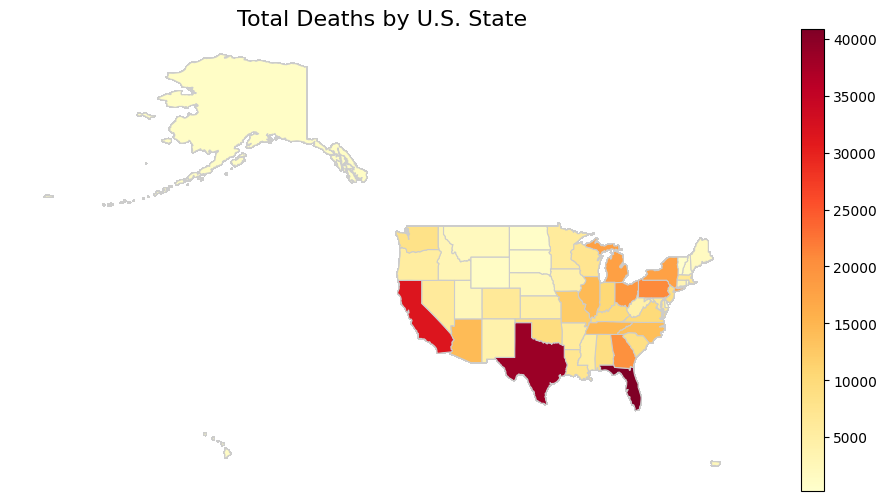

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=100)

merged_df.plot(column='Sum_Deaths', cmap='YlOrRd', legend=True, ax=ax, linewidth=0.8, edgecolor='0.8', k=10)

ax.set_title('Total Deaths by U.S. State', fontsize=16)  # Adjust the font size
ax.set_xlabel('Longitude', fontsize=14)  # Adjust the font size
ax.set_ylabel('Latitude', fontsize=14)  # Adjust the font size

if ax.get_legend():
    # Move the legend to a better position
    legend = ax.get_legend()
    legend.set_bbox_to_anchor((1, 1))
    legend.set_title('Sum_Deaths', fontsize=12)

    legend.set_fontsize(10)

# Set the font size for the colorbar
cbar = ax.get_figure().get_axes()[1]
cbar.tick_params(labelsize=10)
ax.set_axis_off()

plt.show()

# ***Feature engineering***

In [ ]:
# Importing the final dataset that we creating by joining the John Hopkins and CDC Datasets
merged_df = pd.read_csv('final_merged_df.csv')
merged_df.head()

Date  State_FIPS  Administered_Doses_65Plus_Daily  \
0  2021-05-02           1                              0.0   
1  2021-05-02           2                              0.0   
2  2021-05-02           4                              0.0   
3  2021-05-02           5                              0.0   
4  2021-05-02           6                              0.0   

   Series_Complete_65Plus_Daily  Booster_Doses_18Plus_Daily  \
0                           0.0                         0.0   
1                           0.0                         0.0   
2                           0.0                         0.0   
3                           0.0                         0.0   
4                           0.0                         0.0   

   Series_Complete_18Plus_Daily  Administered_Doses_18Plus_Daily  \
0                           0.0                              0.0   
1                           0.0                              0.0   
2                           0.0                              0.0   
3                           0.0                              0.0   
4                           0.0                              0.0   

   Census2019_18PlusPop  Deaths  Confirmed Province_State  FIPS      Lat  \
0             3814879.0       0        288        Alabama     1  32.3182   
1              551562.0       0          0         Alaska     2  61.3707   
2             5638481.0       6        356        Arizona     4  33.7298   
3             2317649.0       2        137       Arkansas     5  34.9697   
4            30617582.0      45       1634     California     6  36.1162   

      Long_  
0  -86.9023  
1 -152.4044  
2 -111.4312  
3  -92.3731  
4 -119.6816

In [ ]:
# Checking if there are any null values
null_percentage = (merged_df.isnull().sum() / len(merged_df)) * 100
print(null_percentage)

Date                               0.0
State_FIPS                         0.0
Administered_Doses_65Plus_Daily    0.0
Series_Complete_65Plus_Daily       0.0
Booster_Doses_18Plus_Daily         0.0
Series_Complete_18Plus_Daily       0.0
Administered_Doses_18Plus_Daily    0.0
Census2019_18PlusPop               0.0
Deaths                             0.0
Confirmed                          0.0
Province_State                     0.0
FIPS                               0.0
Lat                                0.0
Long_                              0.0
dtype: float64


In [ ]:
#Percentage of population who got 1 dose
merged_df['Perc_OneDose'] = (merged_df['Administered_Doses_18Plus_Daily'] * 100) / merged_df['Census2019_18PlusPop'].round()

#Percentage of population who got 2 doses
merged_df['Perc_BothDoses'] = (merged_df['Series_Complete_18Plus_Daily'] * 100) / merged_df['Census2019_18PlusPop'].round()

In [ ]:
# As Virgin Islands has rows where the census pop is 0, removing the virgin ishlands data entirely
merged_df=merged_df[merged_df["Province_State"]!='Virgin Islands'].reset_index()
merged_df.head()

index        Date  State_FIPS  Administered_Doses_65Plus_Daily  \
0      0  2021-05-02           1                              0.0   
1      1  2021-05-02           2                              0.0   
2      2  2021-05-02           4                              0.0   
3      3  2021-05-02           5                              0.0   
4      4  2021-05-02           6                              0.0   

   Series_Complete_65Plus_Daily  Booster_Doses_18Plus_Daily  \
0                           0.0                         0.0   
1                           0.0                         0.0   
2                           0.0                         0.0   
3                           0.0                         0.0   
4                           0.0                         0.0   

   Series_Complete_18Plus_Daily  Administered_Doses_18Plus_Daily  \
0                           0.0                              0.0   
1                           0.0                              0.0   
2                           0.0                              0.0   
3                           0.0                              0.0   
4                           0.0                              0.0   

   Census2019_18PlusPop  Deaths  Confirmed Province_State  FIPS      Lat  \
0             3814879.0       0        288        Alabama     1  32.3182   
1              551562.0       0          0         Alaska     2  61.3707   
2             5638481.0       6        356        Arizona     4  33.7298   
3             2317649.0       2        137       Arkansas     5  34.9697   
4            30617582.0      45       1634     California     6  36.1162   

      Long_  Perc_OneDose  Perc_BothDoses  
0  -86.9023           0.0             0.0  
1 -152.4044           0.0             0.0  
2 -111.4312           0.0             0.0  
3  -92.3731           0.0             0.0  
4 -119.6816           0.0             0.0

In [ ]:
# Checking if Virgin islands data has been removed
merged_df["Province_State"].unique()

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming', 'Guam', 'Puerto Rico'],
      dtype=object)

## Missing Data from June 17th 2022

In [ ]:
merged_df.Date.unique()

array(['2021-05-02', '2021-05-03', '2021-05-04', '2021-05-05',
       '2021-05-06', '2021-05-07', '2021-05-08', '2021-05-09',
       '2021-05-10', '2021-05-11', '2021-05-12', '2021-05-13',
       '2021-05-14', '2021-05-15', '2021-05-16', '2021-05-17',
       '2021-05-18', '2021-05-19', '2021-05-20', '2021-05-21',
       '2021-05-22', '2021-05-23', '2021-05-24', '2021-05-25',
       '2021-05-26', '2021-05-27', '2021-05-28', '2021-05-29',
       '2021-05-30', '2021-05-31', '2021-06-01', '2021-06-02',
       '2021-06-03', '2021-06-04', '2021-06-05', '2021-06-06',
       '2021-06-07', '2021-06-08', '2021-06-09', '2021-06-10',
       '2021-06-11', '2021-06-12', '2021-06-13', '2021-06-14',
       '2021-06-15', '2021-06-16', '2021-06-17', '2021-06-18',
       '2021-06-19', '2021-06-20', '2021-06-21', '2021-06-22',
       '2021-06-23', '2021-06-24', '2021-06-25', '2021-06-26',
       '2021-06-27', '2021-06-28', '2021-06-29', '2021-06-30',
       '2021-07-01', '2021-07-02', '2021-07-03', '2021-

#### We observed that cdc data is not providing every day's data from June 17th 2022. Therefore, we will be using the data till June 16th 2022 for training and testing the model and predict from June 17th 2022 to Septmeber 2022.

In [ ]:
merged_df['Date'] = pd.to_datetime(merged_df['Date'])

# Filter rows until June 16th, 2022
merged_df = merged_df[merged_df['Date'] <= '2022-06-16']

merged_df.tail(10)

index       Date  State_FIPS  Administered_Doses_65Plus_Daily  \
21773  21773 2022-06-16          48                            558.0   
21774  21774 2022-06-16          49                             11.0   
21775  21775 2022-06-16          50                             20.0   
21776  21776 2022-06-16          51                             84.0   
21777  21777 2022-06-16          53                            212.0   
21778  21778 2022-06-16          54                              7.0   
21779  21779 2022-06-16          55                            155.0   
21780  21780 2022-06-16          56                             27.0   
21781  21781 2022-06-16          66                              0.0   
21782  21782 2022-06-16          72                              7.0   

       Series_Complete_65Plus_Daily  Booster_Doses_18Plus_Daily  \
21773                         597.0                      4643.0   
21774                           5.0                        19.0   
21775                          13.0                        97.0   
21776                          79.0                        69.0   
21777                         194.0                      1503.0   
21778                           3.0                        20.0   
21779                         146.0                      1032.0   
21780                          17.0                        75.0   
21781                           7.0                       126.0   
21782                           4.0                         0.0   

       Series_Complete_18Plus_Daily  Administered_Doses_18Plus_Daily  \
21773                        2271.0                           3349.0   
21774                          12.0                             28.0   
21775                          45.0                             47.0   
21776                         146.0                            223.0   
21777                         655.0                            781.0   
21778                          11.0                             24.0   
21779                         433.0                            469.0   
21780                          44.0                             83.0   
21781                          14.0                              0.0   
21782                           7.0                             16.0   

       Census2019_18PlusPop  Deaths  Confirmed Province_State  FIPS      Lat  \
21773            21596071.0       7       8490          Texas    48  31.0545   
21774             2274774.0      13       6522           Utah    49  40.1500   
21775              509984.0       0          0        Vermont    50  44.0459   
21776             6674671.0       2       2526       Virginia    51  37.7693   
21777             5951832.0       0          0     Washington    53  47.4009   
21778             1432580.0       1        654  West Virginia    54  38.4912   
21779             4555837.0       9       1887      Wisconsin    55  44.2685   
21780              445025.0       0          0        Wyoming    56  42.7560   
21781              114544.0       0        121           Guam    66  13.4443   
21782             2620963.0       4       3714    Puerto Rico    72  18.2208   

          Long_  Perc_OneDose  Perc_BothDoses  
21773  -97.5635      0.015507        0.010516  
21774 -111.8624      0.001231        0.000528  
21775  -72.7107      0.009216        0.008824  
21776  -78.1700      0.003341        0.002187  
21777 -121.4905      0.013122        0.011005  
21778  -80.9545      0.001675        0.000768  
21779  -89.6165      0.010294        0.009504  
21780 -107.3025      0.018651        0.009887  
21781  144.7937      0.000000        0.012222  
21782  -66.5901      0.000610        0.000267

In [ ]:
# Find the minimum and maximum values of 'Deaths'
min_deaths = merged_df['Deaths'].min()
max_deaths = merged_df['Deaths'].max()

print(f"Minimum Deaths: {min_deaths}")
print(f"Maximum Deaths: {max_deaths}")

Minimum Deaths: 0
Maximum Deaths: 2441


In [ ]:
# Remove duplicates based on Date and State
df_unique = merged_df.drop_duplicates(subset=['Date', 'Province_State'])

statewise_daily_deaths = df_unique.groupby(['Date', 'Province_State'])['Deaths'].sum().reset_index()
statewise_daily_deaths
df_unique

index       Date  State_FIPS  Administered_Doses_65Plus_Daily  \
0          0 2021-05-02           1                              0.0   
1          1 2021-05-02           2                              0.0   
2          2 2021-05-02           4                              0.0   
3          3 2021-05-02           5                              0.0   
4          4 2021-05-02           6                              0.0   
...      ...        ...         ...                              ...   
21778  21778 2022-06-16          54                              7.0   
21779  21779 2022-06-16          55                            155.0   
21780  21780 2022-06-16          56                             27.0   
21781  21781 2022-06-16          66                              0.0   
21782  21782 2022-06-16          72                              7.0   

       Series_Complete_65Plus_Daily  Booster_Doses_18Plus_Daily  \
0                               0.0                         0.0   
1                               0.0                         0.0   
2                               0.0                         0.0   
3                               0.0                         0.0   
4                               0.0                         0.0   
...                             ...                         ...   
21778                           3.0                        20.0   
21779                         146.0                      1032.0   
21780                          17.0                        75.0   
21781                           7.0                       126.0   
21782                           4.0                         0.0   

       Series_Complete_18Plus_Daily  Administered_Doses_18Plus_Daily  \
0                               0.0                              0.0   
1                               0.0                              0.0   
2                               0.0                              0.0   
3                               0.0                              0.0   
4                               0.0                              0.0   
...                             ...                              ...   
21778                          11.0                             24.0   
21779                         433.0                            469.0   
21780                          44.0                             83.0   
21781                          14.0                              0.0   
21782                           7.0                             16.0   

       Census2019_18PlusPop  Deaths  Confirmed Province_State  FIPS      Lat  \
0                 3814879.0       0        288        Alabama     1  32.3182   
1                  551562.0       0          0         Alaska     2  61.3707   
2                 5638481.0       6        356        Arizona     4  33.7298   
3                 2317649.0       2        137       Arkansas     5  34.9697   
4                30617582.0      45       1634     California     6  36.1162   
...                     ...     ...        ...            ...   ...      ...   
21778             1432580.0       1        654  West Virginia    54  38.4912   
21779             4555837.0       9       1887      Wisconsin    55  44.2685   
21780              445025.0       0          0        Wyoming    56  42.7560   
21781              114544.0       0        121           Guam    66  13.4443   
21782             2620963.0       4       3714    Puerto Rico    72  18.2208   

          Long_  Perc_OneDose  Perc_BothDoses  
0      -86.9023      0.000000        0.000000  
1     -152.4044      0.000000        0.000000  
2     -111.4312      0.000000        0.000000  
3      -92.3731      0.000000        0.000000  
4     -119.6816      0.000000        0.000000  
...         ...           ...             ...  
21778  -80.9545      0.001675        0.000768  
21779  -89.6165      0.010294        0.009504  
21780 -107.3025      0.018651        0.009887  
21781  144.7937      0.000000  

## Time Series Data

In [ ]:
# Creating a univariate dataset that shows daily deaths due to COVID - 19
deaths_df = merged_df.groupby(['Date'])['Deaths'].sum().reset_index()
deaths_df

Date  Deaths
0   2021-05-02     330
1   2021-05-03     486
2   2021-05-04     843
3   2021-05-05     813
4   2021-05-06     796
..         ...     ...
406 2022-06-12      31
407 2022-06-13     281
408 2022-06-14     384
409 2022-06-15     697
410 2022-06-16     449

[411 rows x 2 columns]

In [ ]:
deaths_df.describe()

Deaths
count   411.000000
mean   1075.759124
std     952.842560
min      13.000000
25%     336.500000
50%     673.000000
75%    1744.500000
max    4186.000000

In [ ]:
#Changing the Date column datatype
deaths_df['Date'] = pd.to_datetime(deaths_df['Date'])
deaths_df.sort_values('Date', inplace=True)
deaths_df.dtypes

Date      datetime64[ns]
Deaths             int64
dtype: object

In [ ]:
# Set Date as index
deaths_df.set_index('Date', inplace=True)

## Aggregating date level data

In [ ]:
# Aggregating date level data
date_level_df = merged_df.groupby(['Date']).agg({
    'Administered_Doses_18Plus_Daily' : 'sum' ,
    'Series_Complete_18Plus_Daily' : 'sum' ,
    'Census2019_18PlusPop' : 'sum' ,
    'Deaths': 'sum'
}).reset_index()
date_level_df.head()

Date  Administered_Doses_18Plus_Daily  Series_Complete_18Plus_Daily  \
0 2021-05-02                              0.0                           0.0   
1 2021-05-03                         332967.0                      574722.0   
2 2021-05-04                         366210.0                      644057.0   
3 2021-05-05                         625130.0                     1157082.0   
4 2021-05-06                        1000792.0                      965065.0   

   Census2019_18PlusPop  Deaths  
0           257950637.0     330  
1           257950637.0     486  
2           257950637.0     843  
3           257950637.0     813  
4           257950637.0     796

In [ ]:
#Percentage of population who got 1 dose
date_level_df['Perc_OneDose'] = (date_level_df['Administered_Doses_18Plus_Daily'] * 100) / date_level_df['Census2019_18PlusPop'].round()

#Percentage of population who got 2 doses
date_level_df['Perc_BothDoses'] = (date_level_df['Series_Complete_18Plus_Daily'] * 100) / date_level_df['Census2019_18PlusPop'].round()

date_level_df.head()

Date  Administered_Doses_18Plus_Daily  Series_Complete_18Plus_Daily  \
0 2021-05-02                              0.0                           0.0   
1 2021-05-03                         332967.0                      574722.0   
2 2021-05-04                         366210.0                      644057.0   
3 2021-05-05                         625130.0                     1157082.0   
4 2021-05-06                        1000792.0                      965065.0   

   Census2019_18PlusPop  Deaths  Perc_OneDose  Perc_BothDoses  
0           257950637.0     330      0.000000        0.000000  
1           257950637.0     486      0.129082        0.222803  
2           257950637.0     843      0.141969        0.249682  
3           257950637.0     813      0.242345        0.448567  
4           257950637.0     796      0.387978        0.374128

## Train and Test Split

In [ ]:
# Splitting the data into train and test data
train_end = pd.to_datetime('2022-03-30')
train_data = deaths_df[deaths_df.index <= train_end]
test_data = deaths_df[deaths_df.index > train_end]

In [ ]:
test_data

Deaths
Date              
2022-03-31     514
2022-04-01     829
2022-04-02     159
2022-04-03      60
2022-04-04     583
...            ...
2022-06-12      31
2022-06-13     281
2022-06-14     384
2022-06-15     697
2022-06-16     449

[78 rows x 1 columns]

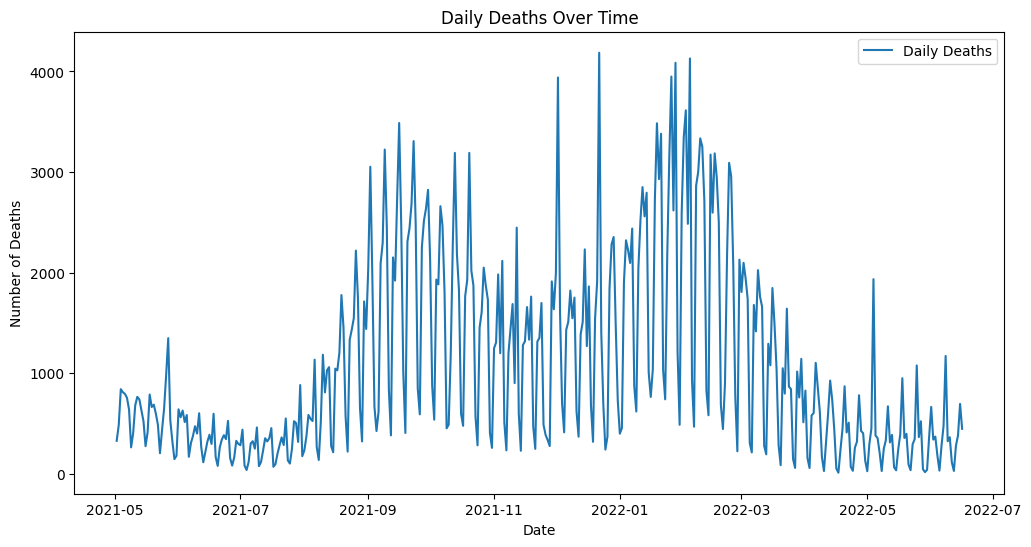

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(deaths_df, label='Daily Deaths')
plt.title('Daily Deaths Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Deaths')
plt.legend()
plt.show()

# ***Models using MLFlow - Phase 1***

---




## **Base Model**

Using MLFlow:-

2023/12/14 03:51:38 INFO mlflow.tracking.fluent: Experiment with name 'ARIMA Model on Death Data' does not exist. Creating a new experiment.
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zero

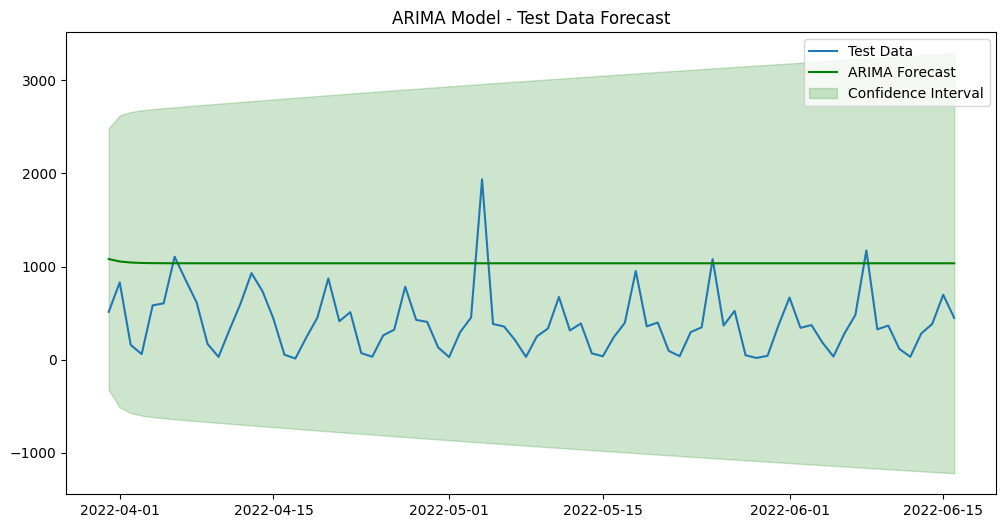

In [ ]:

train_end = pd.to_datetime('2022-03-30')
train_data = deaths_df[deaths_df.index <= train_end]['Deaths']
test_data = deaths_df[deaths_df.index > train_end]['Deaths']

# MLflow experiment
experiment_name = "ARIMA Model on Death Data"
mlflow.set_experiment(experiment_name)

with mlflow.start_run(run_name='Base ARIMA Model'):
    # Define the ARIMA model parameters (p, d, q)
    p = 1  # Autoregressive order
    d = 1  # Differencing order
    q = 1  # Moving average order

    # Log parameters
    mlflow.log_params({"p": p, "d": d, "q": q})

    # Fit the model
    arima_model = ARIMA(train_data, order=(p, d, q))
    arima_result = arima_model.fit()

    # Log model summary
    mlflow.log_text(arima_result.summary().as_text(), "model_summary.txt")

    # Forecasting
    forecast_result = arima_result.get_forecast(steps=len(test_data))
    forecast, conf_int = forecast_result.predicted_mean, forecast_result.conf_int()

    # Calculating metrics
    mse = mean_squared_error(test_data, forecast)
    rmse = sqrt(mse)

    # Log metrics
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("rmse", rmse)

    # Plotting (optional, not logged to MLflow)
    plt.figure(figsize=(12, 6))
    plt.plot(test_data.index, test_data, label='Test Data')
    plt.plot(test_data.index, forecast, color='green', label='ARIMA Forecast')
    plt.fill_between(test_data.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='green', alpha=0.2, label='Confidence Interval')
    plt.title('ARIMA Model - Test Data Forecast')
    plt.legend()
    plt.show()


    # End the run
    mlflow.end_run()

### ***ARIMA Model***

#### Validation dataset:
- auto_arima from the pmdarima library typically employs a stepwise approach for model selection, internally using a validation set without explicitly splitting the provided data into train and validation sets.

In [ ]:
!pip install joblib

2023/12/14 03:51:45 INFO mlflow.tracking.fluent: Experiment with name 'ARIMA Model with auto_arima' does not exist. Creating a new experiment.
/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:62: UserWarning:

m (7) set for non-seasonal fit. Setting to 0



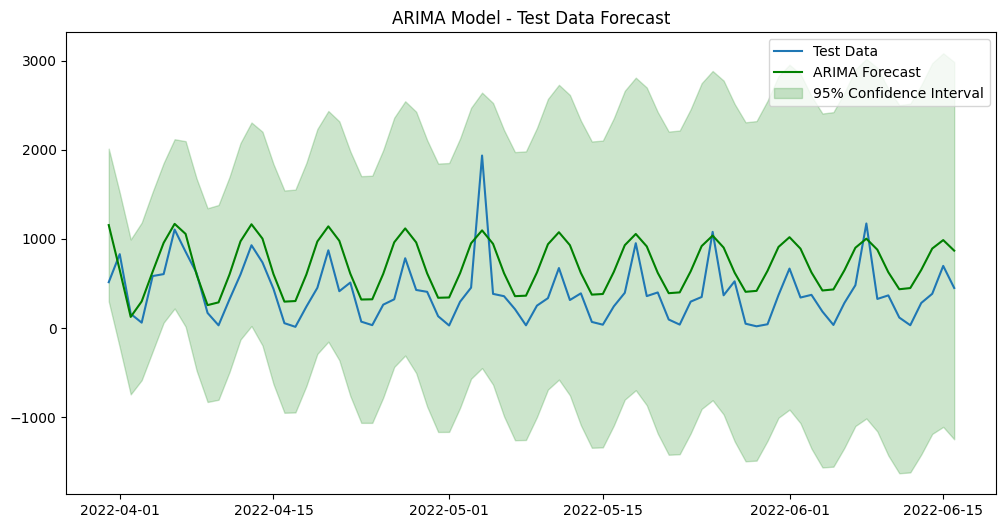

In [ ]:
import joblib
import os

experiment_name = "ARIMA Model with auto_arima"
mlflow.set_experiment(experiment_name)

with mlflow.start_run(run_name='auto_arima Model'):
    # Use auto_arima to find the best ARIMA model
    arima_model = auto_arima(train_data, suppress_warnings=True, seasonal=False, m=7)
    arima_model.fit(train_data)

    # Predict on the test data
    forecast, conf_int = arima_model.predict(n_periods=len(test_data), return_conf_int=True)

    # Calculating metrics
    rmse = sqrt(mean_squared_error(test_data, forecast))
    mae = mean_absolute_error(test_data, forecast)

    # Log parameters, metrics, and model
    mlflow.log_params({
        "order": arima_model.order,
        "seasonal_order": arima_model.seasonal_order,
        "m": 7
    })
    mlflow.log_metrics({
        "rmse": rmse,
        "mae": mae
    })

    # Log the model
    # mlflow.log_artifact(arima_model, "arima_model")

     # Save the model to a file
    model_file_path = "arima_model.pkl"
    joblib.dump(arima_model, model_file_path)

    # Log the model file
    mlflow.log_artifact(model_file_path)

    # Clean up: remove the model file if you don't want it locally
    os.remove(model_file_path)

    plt.figure(figsize=(12, 6))
    plt.plot(test_data, label='Test Data')
    plt.plot(forecast, color='green', label='ARIMA Forecast')
    plt.fill_between(test_data.index, conf_int[:, 0], conf_int[:, 1], color='green', alpha=0.2, label='95% Confidence Interval')
    plt.title('ARIMA Model - Test Data Forecast')
    plt.legend()
    plt.show()

    # End the run
    mlflow.end_run()

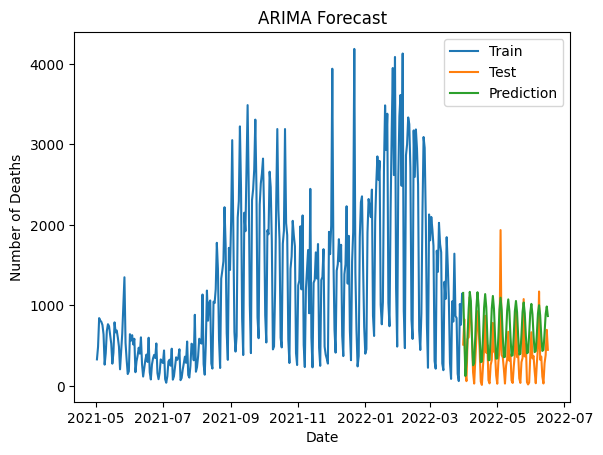

In [ ]:
#plot the predictions for validation set
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(forecast, label='Prediction')
plt.title("ARIMA Forecast")
plt.xlabel("Date")
plt.ylabel("Number of Deaths")
plt.legend()
plt.show()

In [ ]:
# Get the model parameters
order = arima_model.order
seasonal_order = arima_model.seasonal_order

print("ARIMA Order:", order)
print("Seasonal Order:", seasonal_order)
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.4f}")

ARIMA Order: (5, 1, 2)
Seasonal Order: (0, 0, 0, 0)
Root Mean Squared Error: 379.83
Mean Absolute Error: 340.6260


- ARIMA (AutoRegressive Integrated Moving Average) is a widely used statistical method for time series forecasting. It combines autoregressive (AR), differencing (I), and moving average (MA) components to model and predict future values based on past observations in a time series data.
- Our ARIMA model is proving effective, mirroring the test data closely in its forecasts.
- Our accuracy metrics showcase promising results with an RMSE (Root Mean Squared Error) of 380 and an MAE (Mean Absolute Error) of 340.

### ***SARIMA Model***

#### Validation dataset:
- auto_arima from the pmdarima library typically employs a stepwise approach for model selection, internally using a validation set without explicitly splitting the provided data into train and validation sets.

2023/12/14 03:52:34 INFO mlflow.tracking.fluent: Experiment with name 'SARIMA Model for Death Prediction' does not exist. Creating a new experiment.


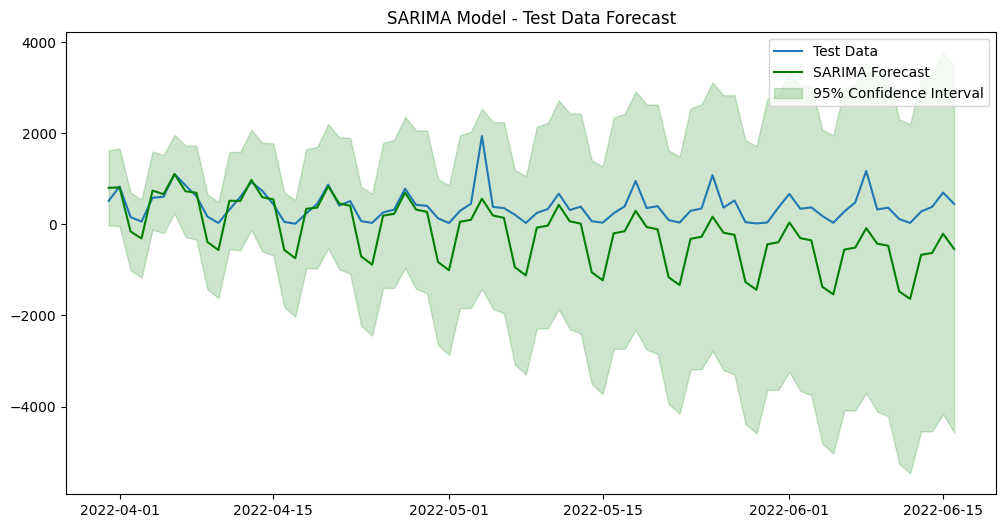

ARIMA Order: (3, 1, 2)
Seasonal Order: (2, 0, 1, 7)
Root Mean Squared Error: 763.29
Mean Absolute Error: 605.5062


In [ ]:
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import mlflow
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import sqrt

# Start MLflow run
mlflow.set_experiment("SARIMA Model for Death Prediction")
with mlflow.start_run(run_name='SARIMA_Death_Prediction'):

    # Use auto_arima to find the best SARIMA model
    sarima_model = auto_arima(train_data, suppress_warnings=True, error_action='ignore', seasonal=True, m=7)
    sarima_model.fit(train_data)

    # Make predictions on the test data
    sarima_forecast, conf_int = sarima_model.predict(n_periods=len(test_data), return_conf_int=True)

    # Plot the test data and predictions
    plt.figure(figsize=(12, 6))
    plt.plot(test_data, label='Test Data')
    plt.plot(sarima_forecast, color='green', label='SARIMA Forecast')
    plt.fill_between(test_data.index, conf_int[:, 0], conf_int[:, 1], color='green', alpha=0.2, label='95% Confidence Interval')
    plt.title('SARIMA Model - Test Data Forecast')
    plt.legend()
    plt.show()

    # Get the model parameters
    order = sarima_model.order
    seasonal_order = sarima_model.seasonal_order

    # Calculate metrics
    rmse = sqrt(mean_squared_error(test_data, sarima_forecast))
    mae = mean_absolute_error(test_data, sarima_forecast)

    # Log parameters and metrics
    mlflow.log_params({"order": order, "seasonal_order": seasonal_order})
    mlflow.log_metrics({"rmse": rmse, "mae": mae})

    # End the MLflow run
    mlflow.end_run()

print(f"ARIMA Order: {order}")
print(f"Seasonal Order: {seasonal_order}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.4f}")


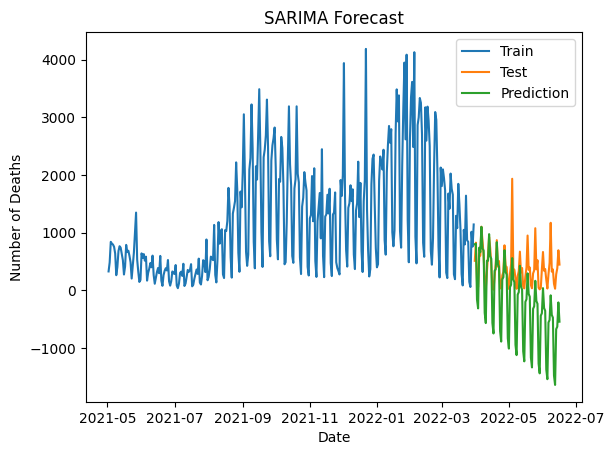

In [ ]:
#plot the predictions for validation set
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(sarima_forecast, label='Prediction')
plt.title("SARIMA Forecast")
plt.xlabel("Date")
plt.ylabel("Number of Deaths")
plt.legend()
plt.show()

- SARIMA (Seasonal AutoRegressive Integrated Moving Average) extends ARIMA by considering seasonal patterns in time series data. It captures not only trends and cycles but also seasonal fluctuations to make more accurate forecasts, especially when data exhibits periodic patterns over time.
- SARIMA model performance isn't aligned with our dataset, predicting a downward trend in the test data that doesn't exist.
- Notably, it exhibits an RMSE of 760, almost twice the value of the ARIMA model.
- Evidently, for our dataset, the ARIMA model outperforms SARIMA significantly, showcasing its superiority in accuracy and trend prediction.

In [ ]:
order = sarima_model.order
seasonal_order = sarima_model.seasonal_order

print("ARIMA Order:", order)
print("Seasonal Order:", seasonal_order)
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.4f}")

ARIMA Order: (3, 1, 2)
Seasonal Order: (2, 0, 1, 7)
Root Mean Squared Error: 328.91
Mean Absolute Error: 264.8904


In [ ]:
pd.DataFrame(test_data).describe()

Deaths
count    78.000000
mean    398.192308
std     332.886629
min      13.000000
25%     161.500000
50%     357.500000
75%     513.000000
max    1936.000000

## ***Regression Model***

In [ ]:
# Checking if the number of rows in the date level data and number of unque dates in the merged_df is the same
print("Number of rows in the date level data: ",date_level_df.shape[0])
print("Number of unique dates in the merged_df: ",merged_df["Date"].nunique())

Number of rows in the date level data:  411
Number of unique dates in the merged_df:  411


### Regression using date and double doses count

- y = ax1 + bx2
- deaths = a*date + b*Series_Complete_18Plus_Daily

In [ ]:
date_level_df['Date'] = pd.to_datetime(date_level_df['Date'])
date_level_df.sort_values(by='Date', inplace=True)

# Create lagged features for 'Number of Doses' with lag 1 and lag 2
date_level_df['BothDoses_Lag1'] = date_level_df['Series_Complete_18Plus_Daily'].shift(1)  # Lag 1: Shift previous value by 1
date_level_df['BothDoses_Lag7'] = date_level_df['Series_Complete_18Plus_Daily'].shift(7)  # Lag 7: Shift previous value by 7

# Drop rows with NaN resulting from the shift operation
date_level_df.dropna(inplace=True)

# Now, 'date_level_df' contains lagged values of 'Number of Doses' in 'Doses_Lag1' and 'Doses_Lag2'
date_level_df.head()

Date  Administered_Doses_18Plus_Daily  Series_Complete_18Plus_Daily  \
7  2021-05-09                         492528.0                     1046856.0   
8  2021-05-10                         597866.0                     1173819.0   
9  2021-05-11                         488502.0                      948357.0   
10 2021-05-12                         393198.0                      912834.0   
11 2021-05-13                         464220.0                     1008082.0   

    Census2019_18PlusPop  Deaths  Perc_OneDose  Perc_BothDoses  \
7            257950637.0     265      0.190939        0.405836   
8            257950637.0     407      0.231775        0.455056   
9            257950637.0     683      0.189378        0.367651   
10           257950637.0     767      0.152431        0.353879   
11           257950637.0     742      0.179965        0.390804   

    BothDoses_Lag1  BothDoses_Lag7  
7        1409935.0             0.0  
8        1046856.0        574722.0  
9        1173819.0        644057.0  
10        948357.0       1157082.0  
11        912834.0        965065.0

In [ ]:
date_level_df

Date  Administered_Doses_18Plus_Daily  Series_Complete_18Plus_Daily  \
7   2021-05-09                         492528.0                     1046856.0   
8   2021-05-10                         597866.0                     1173819.0   
9   2021-05-11                         488502.0                      948357.0   
10  2021-05-12                         393198.0                      912834.0   
11  2021-05-13                         464220.0                     1008082.0   
..         ...                              ...                           ...   
406 2022-06-12                          20791.0                       17398.0   
407 2022-06-13                          11560.0                        8522.0   
408 2022-06-14                          30260.0                       27726.0   
409 2022-06-15                          75741.0                       80431.0   
410 2022-06-16                          35311.0                       29076.0   

     Census2019_18PlusPop  Deaths  Perc_OneDose  Perc_BothDoses  \
7             257950637.0     265      0.190939        0.405836   
8             257950637.0     407      0.231775        0.455056   
9             257950637.0     683      0.189378        0.367651   
10            257950637.0     767      0.152431        0.353879   
11            257950637.0     742      0.179965        0.390804   
..                    ...     ...           ...             ...   
406           257935880.0      31      0.008061        0.006745   
407           257935880.0     281      0.004482        0.003304   
408           257935880.0     384      0.011732        0.010749   
409           257935880.0     697      0.029364        0.031183   
410           257935880.0     449      0.013690        0.011273   

     BothDoses_Lag1  BothDoses_Lag7  
7         1409935.0             0.0  
8         1046856.0        574722.0  
9         1173819.0        644057.0  
10         948357.0       1157082.0  
11         912834.0        965065.0  
..              ...             ...  
406         35584.0         19071.0  
407         17398.0          9903.0  
408          8522.0         37071.0  
409         27726.0         44615.0  
410         80431.0         42848.0  

[404 rows x 9 columns]

In [ ]:
train_data = date_level_df[date_level_df["Date"] <= '2022-03-30']
test_data = date_level_df[date_level_df["Date"] > '2022-03-30']

# Features and target variable for train and test sets
X_train = train_data[['Series_Complete_18Plus_Daily','BothDoses_Lag1','BothDoses_Lag7']]  # Features
y_train = train_data['Deaths']  # Target variable
X_test = test_data[['Series_Complete_18Plus_Daily','BothDoses_Lag1','BothDoses_Lag7']]
y_test = test_data['Deaths']

2023/12/14 03:55:57 INFO mlflow.tracking.fluent: Experiment with name 'Linear Regression Model for Death Prediction' does not exist. Creating a new experiment.


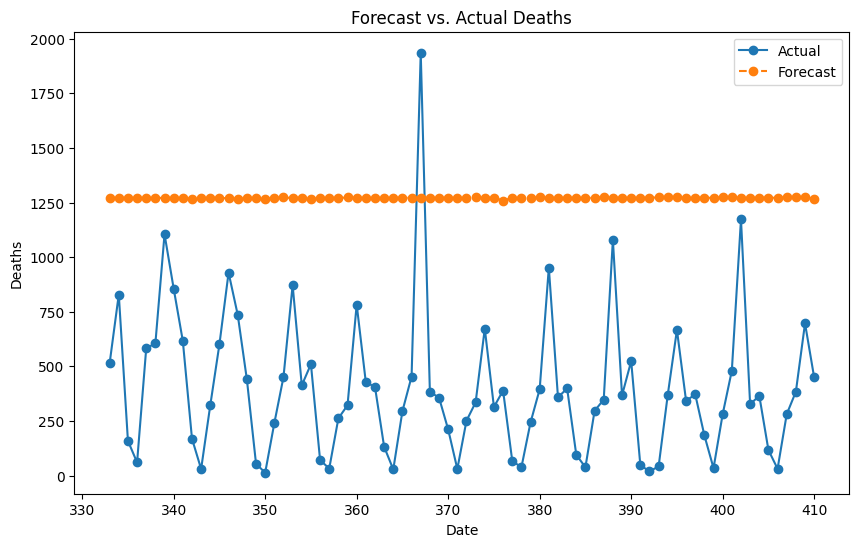

Test R^2 score using Linear Regression model: -6.9660


In [ ]:
# Start MLflow run
mlflow.set_experiment("Linear Regression Model for Death Prediction")
with mlflow.start_run(run_name='LR_Death_Prediction'):

    # Initialize and fit the Linear Regression model
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)

    # Predict using the trained model on test data
    y_pred = lr_model.predict(X_test)

    # Calculate metrics
    test_r2 = r2_score(y_test, y_pred)

    # Log model and metrics
    mlflow.sklearn.log_model(lr_model, "linear_regression_model")
    mlflow.log_metric("r2_score", test_r2)

    # Plotting forecast vs. actual
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.index, y_test, label='Actual', marker='o')
    plt.plot(y_test.index, y_pred, label='Forecast', linestyle='dashed', marker='o')
    plt.title('Forecast vs. Actual Deaths')
    plt.xlabel('Date')
    plt.ylabel('Deaths')
    plt.legend()
    plt.show()

    # End the MLflow run
    mlflow.end_run()

print(f"Test R^2 score using Linear Regression model: {test_r2:.4f}")


### Regression using all the features

In [ ]:
date_level_df['Date'] = pd.to_datetime(date_level_df['Date'])
date_level_df.set_index('Date', inplace=True)  # Set 'Date' column as index

In [ ]:
X = date_level_df.drop('Deaths', axis=1)  # Features
y = date_level_df['Deaths']  # Target variable

train_data = date_level_df[date_level_df.index <= '2022-03-30']
test_data = date_level_df[date_level_df.index > '2022-03-30']

# Features and target variable for train and test sets
X_train = train_data.drop('Deaths', axis=1)
y_train = train_data['Deaths']
X_test = test_data.drop('Deaths', axis=1)
y_test = test_data['Deaths']

In [ ]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict using the trained model on test data
y_pred = lr_model.predict(X_test)

# Calculate R^2 score for the test data
test_r2 = r2_score(y_test, y_pred)
print(f"Test R^2 score using Linear Regression model: {test_r2:.4f}")

Test R^2 score using Linear Regression model: -11.0275


### Regression model using 3 top features

In [ ]:
# Feature selection using SelectKBest with f_regression scoring function
selector = SelectKBest(score_func=f_regression, k=3)  # Select top 3 features
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)


In [ ]:
lr_model = LinearRegression()
lr_model.fit(X_train_selected, y_train)

# Predict using the trained model on test data
y_pred = lr_model.predict(X_test_selected)

# Calculate R^2 score for the test data
test_r2 = r2_score(y_test, y_pred)
print(f"Test R^2 score using Linear Regression model: {test_r2:.4f}")

Test R^2 score using Linear Regression model: -12.7128


In [ ]:
# Get selected feature names
selected_feature_names = X.columns[selector.get_support(indices=True)]
print(f"Selected Features: {selected_feature_names}")

Selected Features: Index(['Census2019_18PlusPop', 'Perc_OneDose', 'BothDoses_Lag1'], dtype='object')


- No regression models are observed to be working well.

## ***LSTM***

2023/12/14 03:56:02 INFO mlflow.tracking.fluent: Experiment with name 'LSTM Model for Death Prediction' does not exist. Creating a new experiment.


Epoch 1/50
11/11 [==============================] - 6s 114ms/step - loss: 0.0853 - val_loss: 0.0178
Epoch 2/50
11/11 [==============================] - 0s 16ms/step - loss: 0.0438 - val_loss: 0.0179
Epoch 3/50
11/11 [==============================] - 0s 15ms/step - loss: 0.0368 - val_loss: 0.0098
Epoch 4/50
11/11 [==============================] - 0s 14ms/step - loss: 0.0341 - val_loss: 0.0127
Epoch 5/50
11/11 [==============================] - 0s 17ms/step - loss: 0.0316 - val_loss: 0.0065
Epoch 6/50
11/11 [==============================] - 0s 15ms/step - loss: 0.0319 - val_loss: 0.0065
Epoch 7/50
11/11 [==============================] - 0s 15ms/step - loss: 0.0308 - val_loss: 0.0059
Epoch 8/50
11/11 [==============================] - 0s 17ms/step - loss: 0.0316 - val_loss: 0.0058
Epoch 9/50
11/11 [==============================] - 0s 16ms/step - loss: 0.0294 - val_loss: 0.0056
Epoch 10/50
11/11 [==============================] - 0s 16ms/step - loss: 0.0274 - val_loss: 0.0056
Epoch 11

2023/12/14 03:56:21 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


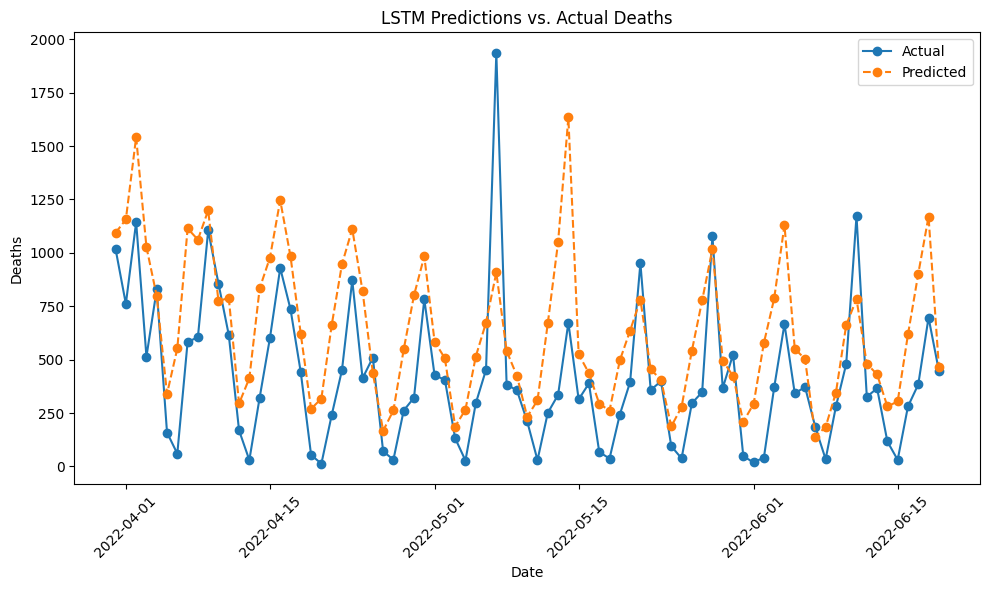

Root Mean Squared Error: 328.9073
Mean Absolute Error: 264.8904


In [ ]:
import mlflow.keras

df = deaths_df.copy()
data = df['Deaths'].values.reshape(-1, 1)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length]
        X.append(seq)
        y.append(label)
    return np.array(X), np.array(y)

sequence_length = 7
X, y = create_sequences(scaled_data, sequence_length)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Start MLflow run
mlflow.set_experiment("LSTM Model for Death Prediction")
with mlflow.start_run(run_name='LSTM_Death_Prediction'):

    # Build LSTM model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=50))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

    # Predict on the test data
    predicted = model.predict(X_test)
    predicted = scaler.inverse_transform(predicted)
    y_test = scaler.inverse_transform(y_test)

    # Calculate metrics
    mse = mean_squared_error(y_test, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predicted)

    # Log parameters and metrics
    mlflow.log_params({"units": 50, "epochs": 50, "batch_size": 32})
    mlflow.log_metrics({"mse": mse, "rmse": rmse, "mae": mae})

    # Log the model
    mlflow.keras.log_model(model, "lstm_model")

    # End the MLflow run
    mlflow.end_run()

# Plotting predictions vs. actual with dates on the x-axis
start_date = '2022-03-31'
date_range = pd.date_range(start=start_date, periods=len(y_test), freq='D')
plt.figure(figsize=(10, 6))
plt.plot(date_range, y_test, label='Actual', marker='o')
plt.plot(date_range, predicted, label='Predicted', linestyle='dashed', marker='o')
plt.title('LSTM Predictions vs. Actual Deaths')
plt.xlabel('Date')
plt.ylabel('Deaths')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")

- LSTM (Long Short-Term Memory) models are specialized recurrent neural networks ideal for time series forecasting. They excel at capturing long-range dependencies and patterns within sequential data, making them powerful for understanding and predicting time-based trends.
- The LSTM model shows a lower RMSE compared to the ARIMA model, suggesting better accuracy in terms of error measurement.
- However, upon visual inspection between the model forecast and the test data, it's evident that the LSTM model simply mimics a lag of the actual data in its forecasts. Tt lacks the ability to capture the complexity and nuances necessary for longer-term predictions.
- In essence, it's reproducing past patterns with a delay rather than projecting meaningful future trends, limiting its reliability for extended forecasting.
- Therefore, ARIMA model still stands as the best model for our dataset.

# ***Models using MLFlow - Phase 2***

In [ ]:
with mlflow.start_run(run_name="MLflow on Colab"):
  mlflow.log_metric("m1", 2.0)
  mlflow.log_param("p1", "mlflow-colab")

# run tracking UI in the background
get_ipython().system_raw("mlflow ui --port 5000 &")

In [ ]:
!wget -q https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip

In [ ]:
!unzip -qq ngrok-stable-linux-amd64.zip

In [ ]:
get_ipython().system_raw('./ngrok http 5000 &')

In [ ]:
!curl -s http://localhost:4040/api/tunnels | python3 -c "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib/python3.10/json/__init__.py", line 293, in load
    return loads(fp.read(),
  File "/usr/lib/python3.10/json/__init__.py", line 346, in loads
    return _default_decoder.decode(s)
  File "/usr/lib/python3.10/json/decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "/usr/lib/python3.10/json/decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)


In [ ]:
# Terminate open tunnels if exist
ngrok.kill()

# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = "2ZTKYXxVsRWw3ymiU72x2coBNLp_6ZpWv9AKXAedTtteQ6gun"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

MLflow Tracking UI: https://9998-35-231-54-100.ngrok-free.app


RANDOM FOREST

---


In [ ]:
merged_df = pd.read_csv('final_merged_df.csv')
merged_df['Date'] = pd.to_datetime(merged_df['Date'])
merged_df['DayOfYear'] = merged_df['Date'].dt.dayofyear

features = ['DayOfYear', 'Confirmed', 'Administered_Doses_18Plus_Daily', 'Series_Complete_18Plus_Daily']
X = merged_df[features]

# Target variable
y = merged_df['Deaths']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Set the MLflow tracking URI to the address where the server is running
mlflow.set_tracking_uri('http://localhost:5000')

with mlflow.start_run():
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Log model and parameters
    mlflow.sklearn.log_model(model, "random_forest_model")
    mlflow.log_params({"model_type": "random_forest", "n_estimators": 100})

    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)

    # Log metrics
    mlflow.log_metric("mse", mse)

    # End the MLflow run is implicit when using the context manager

/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning:

Setuptools is replacing distutils.



In [ ]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)

print(f"Mean Squared Error: {mse}")

Mean Squared Error: 2549.426705467624


In [ ]:
new_data = pd.DataFrame({
    'DayOfYear': [100],
    'Confirmed': [1000],
    'Administered_Doses_18Plus_Daily': [5000],
    'Series_Complete_18Plus_Daily': [3000]
})
predicted_deaths = model.predict(new_data)

print(f"Predicted Deaths: {predicted_deaths[0]}")

Predicted Deaths: 14.33


SARIMA MODEL

---

In [ ]:
# Perform Augmented Dickey-Fuller test

daily_deaths = merged_df.groupby('Date')['Deaths'].sum()

# Perform the Augmented Dickey-Fuller test
result = adfuller(daily_deaths.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# Interpretation
if result[1] > 0.05:
    print("Series is not stationary")
else:
    print("Series is stationary")

ADF Statistic: -1.897965
p-value: 0.333019
Series is not stationary


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

p, d, q = 1, 1, 1  # Initial guess, adjust based on ACF and PACF plots
P, D, Q, S = 1, 1, 1, 7  # Assuming a weekly seasonality

sarima_model = SARIMAX(daily_deaths,
                       order=(p, d, q),
                       seasonal_order=(P, D, Q, S),
                       enforce_stationarity=False,
                       enforce_invertibility=False)

sarima_result = sarima_model.fit()

print(sarima_result.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                                     SARIMAX Results                                     
Dep. Variable:                            Deaths   No. Observations:                  426
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -3030.030
Date:                           Thu, 14 Dec 2023   AIC                           6070.060
Time:                                   03:50:58   BIC                           6090.129
Sample:                                        0   HQIC                          6078.001
                                           - 426                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1510      0.050      3.017      0.003       0.053       0.249
ma.L1         -0.8754      0.028    -31.139

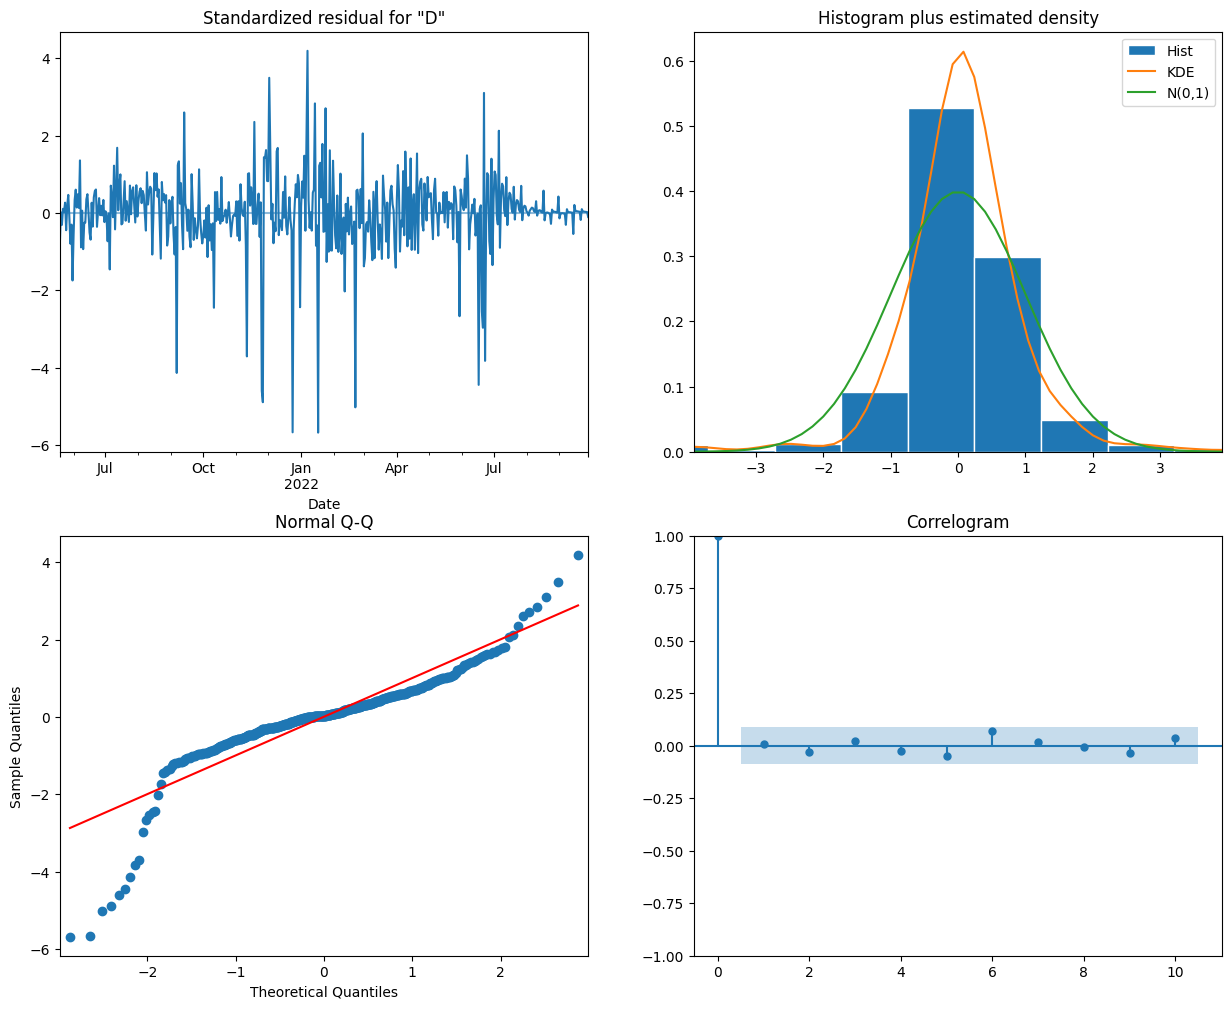

Ljung-Box test: lb_stat
p-values: lb_pvalue


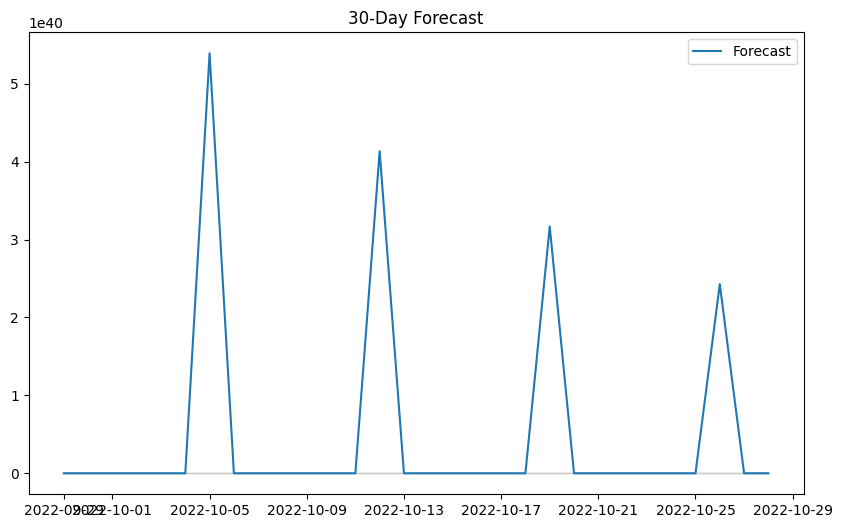

In [ ]:
merged_df['Deaths_log'] = np.log(merged_df['Deaths'] + 1)

merged_df['Date'] = pd.to_datetime(merged_df['Date'])
merged_df.set_index('Date', inplace=True)

daily_deaths_log = merged_df['Deaths_log'].resample('D').sum()

model = SARIMAX(daily_deaths_log,
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 7),
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit()

# Model diagnostics
results.plot_diagnostics(figsize=(15, 12))
plt.show()

# Ljung-Box test
ljung_box, p_value = acorr_ljungbox(results.resid)
print(f'Ljung-Box test: {ljung_box[:10]}')
print(f'p-values: {p_value[:10]}')

# Forecasting
forecast = results.get_forecast(steps=30)
forecast_conf_int = forecast.conf_int()
forecast_predicted_mean = forecast.predicted_mean

# Transform back if necessary
forecast_predicted_mean = np.exp(forecast_predicted_mean) - 1

plt.figure(figsize=(10, 6))
plt.plot(forecast_predicted_mean, label='Forecast')
plt.fill_between(forecast_conf_int.index,
                 forecast_conf_int.iloc[:, 0],
                 forecast_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.title('30-Day Forecast')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning:

overflow encountered in exp



2022-09-29   -0.445410
2022-09-30   -0.391829
2022-10-01   -0.379420
2022-10-02   -0.376448
2022-10-03   -0.371719
2022-10-04   -0.369478
2022-10-05         inf
2022-10-06   -0.466677
2022-10-07   -0.450657
2022-10-08   -0.448709
2022-10-09   -0.448337
2022-10-10   -0.445535
2022-10-11   -0.444120
2022-10-12         inf
2022-10-13   -0.510983
2022-10-14   -0.499784
2022-10-15   -0.498430
2022-10-16   -0.498172
2022-10-17   -0.496221
2022-10-18   -0.495235
2022-10-19         inf
2022-10-20   -0.542451
2022-10-21   -0.534443
2022-10-22   -0.533477
2022-10-23   -0.533294
2022-10-24   -0.531904
2022-10-25   -0.531202
2022-10-26         inf
2022-10-27   -0.565189
2022-10-28   -0.559368
Freq: D, Name: predicted_mean, dtype: float64


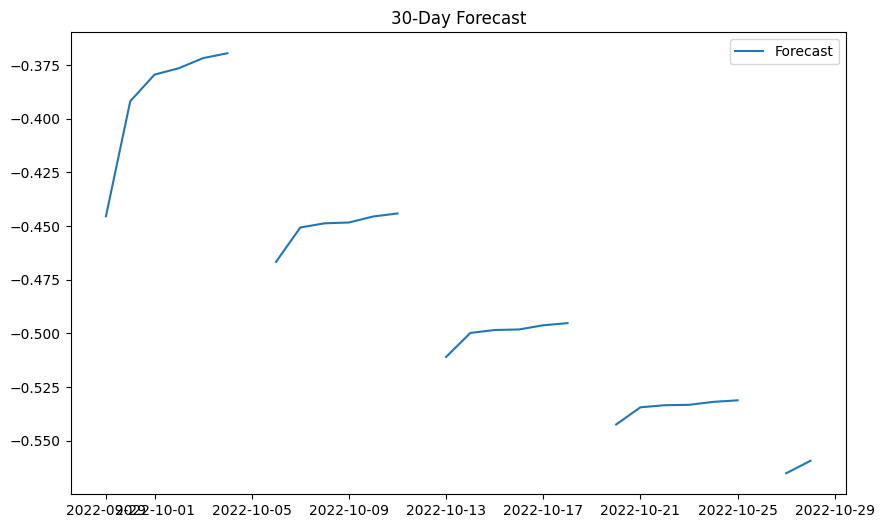

In [ ]:
forecasted_values = np.exp(forecast_predicted_mean) - 1

# Check the transformed forecasted values
print(forecasted_values)

plt.figure(figsize=(10, 6))
plt.plot(forecasted_values, label='Forecast')
plt.title('30-Day Forecast')
plt.legend()
plt.show()

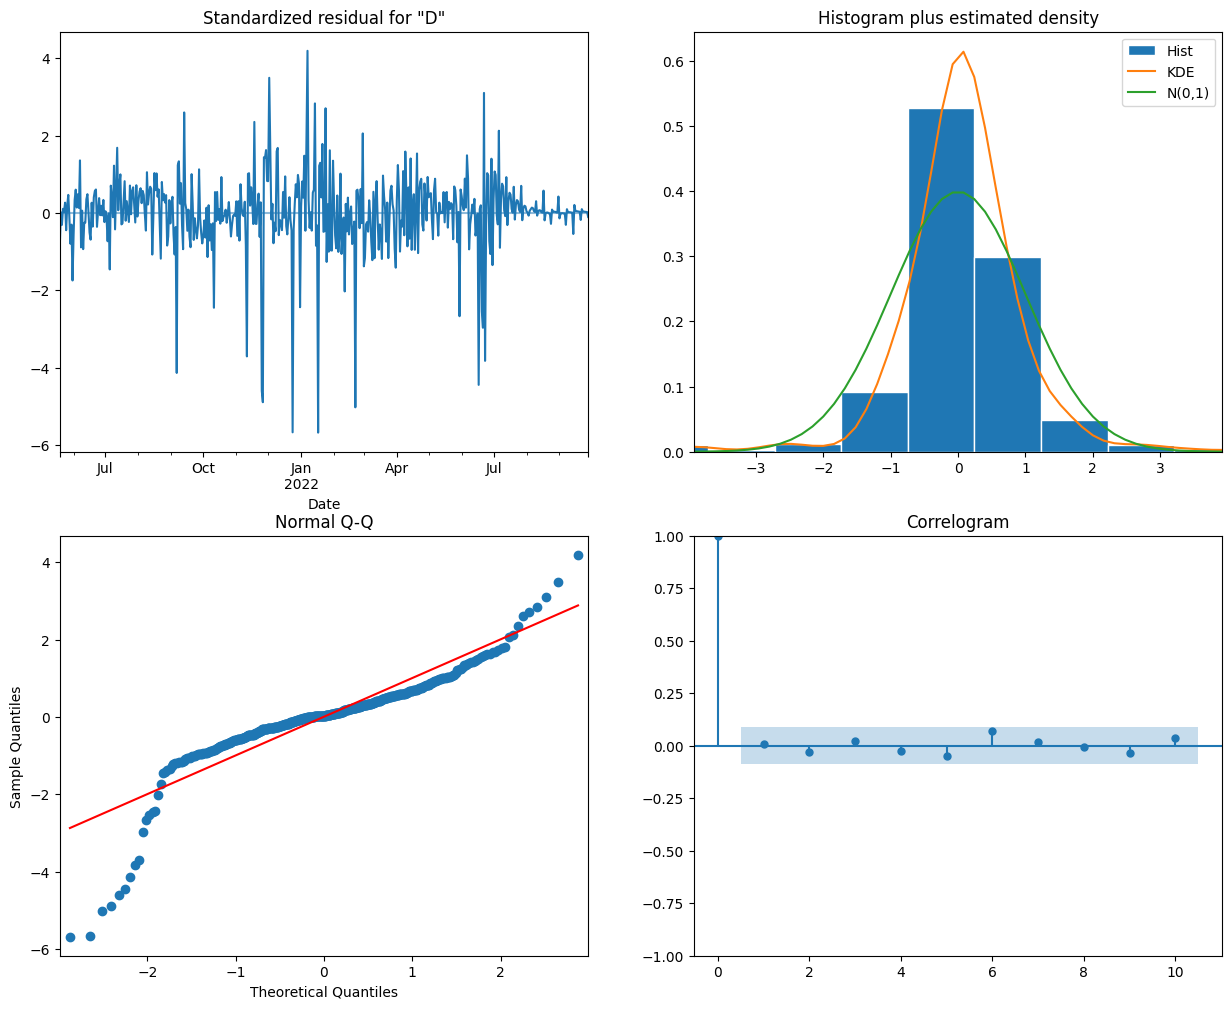

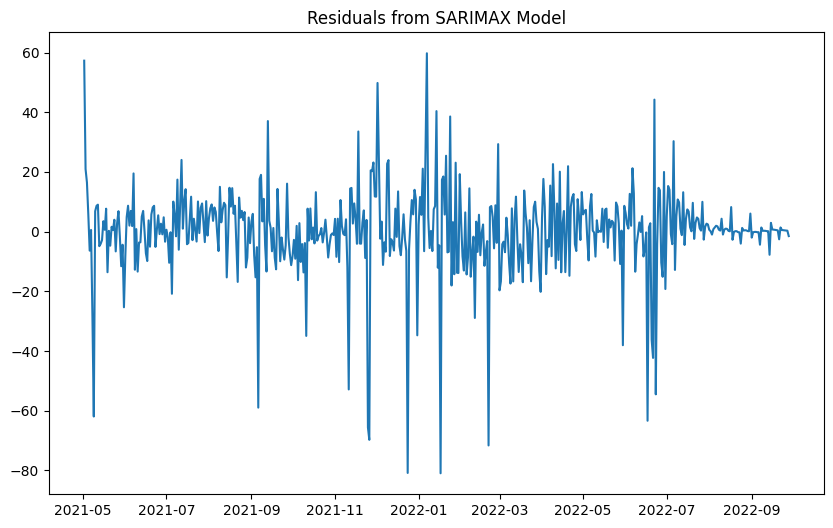

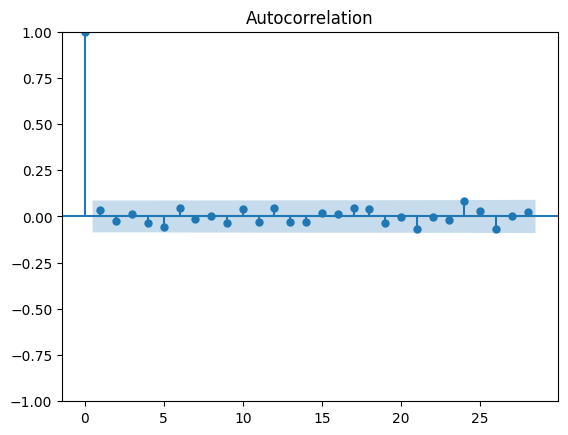

In [ ]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

residuals = results.resid
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals from SARIMAX Model')
plt.show()

# Check for autocorrelation in residuals
plot_acf(residuals)
plt.show()

Provided above, show the diagnostic plots and the 30-day forecast from the SARIMAX model. The diagnostics suggest that the residuals are within acceptable bounds for autocorrelation, but the distribution of the residuals indicates some deviation from normality, particularly in the tails. The forecast plot shows gaps, suggesting missing dates or non-sequential predictions.

In [ ]:
test_df = pd.read_csv('final_merged_df.csv')

test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df.set_index('Date', inplace=True)

# The 'Deaths' column should contain the actual observed death counts
actual_values = test_df['Deaths']

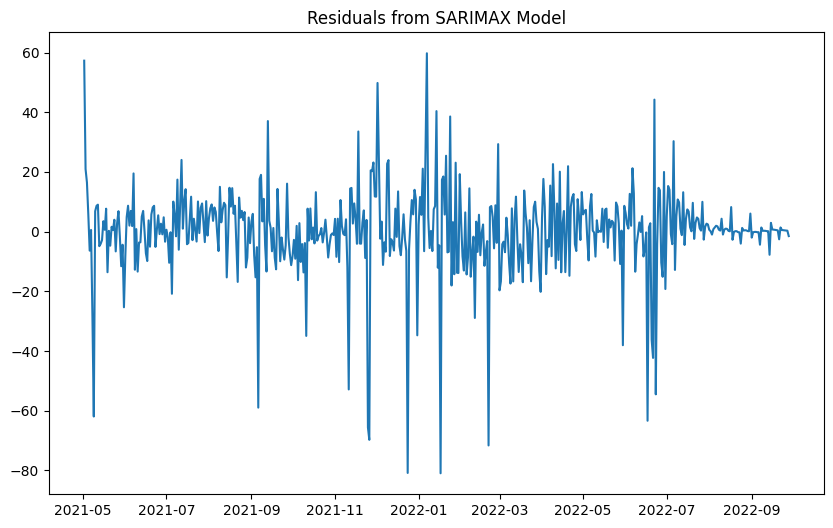

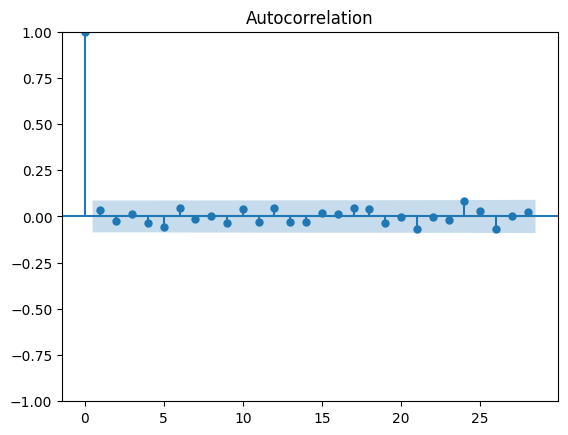

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning:

overflow encountered in exp



MAE: nan, RMSE: nan


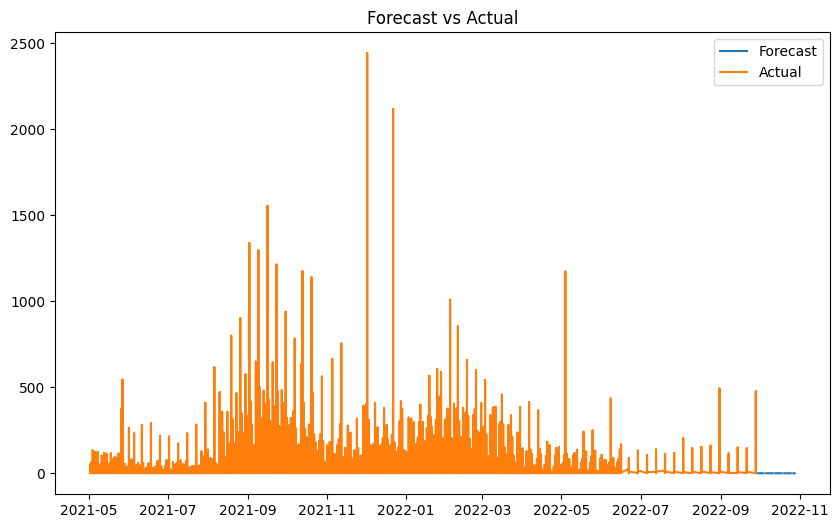

In [ ]:
# Residual Analysis
residuals = results.resid

plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals from SARIMAX Model')
plt.show()

# Calculate and plot autocorrelation of residuals
plot_acf(residuals)
plt.show()

forecast_values = np.exp(forecast_predicted_mean) - 1 # revert log transformation if used
mae = np.mean(np.abs(forecast_values - actual_values))
rmse = np.sqrt(np.mean((forecast_values - actual_values) ** 2))
print(f'MAE: {mae}, RMSE: {rmse}')

# Plot forecast against actual values
plt.figure(figsize=(10, 6))
plt.plot(forecast_values, label='Forecast')
plt.plot(actual_values, label='Actual')
plt.title('Forecast vs Actual')
plt.legend()
plt.show()


The diagnostic plots and the forecast versus actual plot provided here give insight into the performance of your SARIMAX model.

**Residuals Plot:** The residuals over time don't show obvious patterns, which suggests that the model has captured the time series' structure well. However, the variability of residuals appears to change over time, indicating potential heteroscedasticity.

**Autocorrelation Plot:** The correlogram shows that the residuals are not autocorrelated, which is good as it means the model is capturing the time series dependency structure adequately.

Forecast vs Actual Plot: The forecasted values against the actual values plot suggests that while the model captures the general trend, it fails to predict the magnitude of the peaks accurately.


# ***Forecasting the daily deaths from June 17th 2022 to September 2022***


- Here, we are using the entire data,i.e., upto June 16th 2022 to run the best models that we found above and forecast the daily deaths from June 17th to September 30th 2022.

## Predicting daily deaths from June 17th 2022 to September 2022

- In the earlier model evaluation, we observed that SARIMA and LSTM have performed well.
- Therefore, we will use those models and predict for the next dates.

In [ ]:
# Splitting the data into train and test data
train_end = pd.to_datetime('2022-06-16')
train_data = deaths_df[deaths_df.index <= train_end]

In [ ]:
train_data

Deaths
Date              
2021-05-02     274
2021-05-03     452
2021-05-04     762
2021-05-05     710
2021-05-06     671
...            ...
2022-06-12      18
2022-06-13     241
2022-06-14     277
2022-06-15     635
2022-06-16     424

[411 rows x 1 columns]

### ARIMA Model


In [ ]:
from datetime import datetime

# Define the start and end dates
start_date = datetime(2022, 6, 17)
end_date = datetime(2022, 9, 30)  # End of September 2022

# Calculate the number of days between the dates
num_days = (end_date - start_date).days + 1  # Adding 1 to include both start and end dates

print(f"Number of days between June 17th and end of September 2022: {num_days} days")

Number of days between June 17th and end of September 2022: 106 days


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

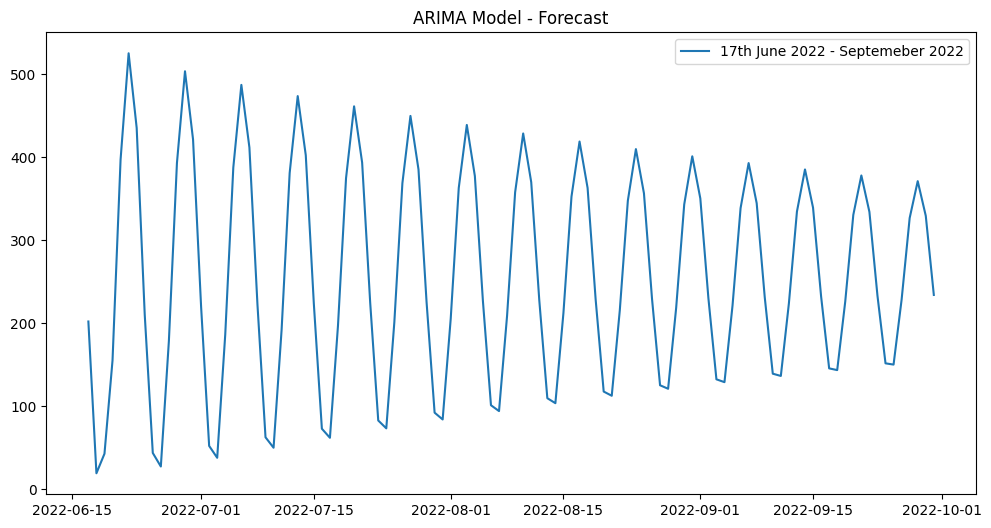

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Replace 'time_series_data' with your actual time series data
# Initialize and fit the ARIMA model
model = ARIMA(train_data, order=(5, 1, 2))
arima_model = model.fit()

# Make predictions on the test data
forecast = arima_model.forecast(steps=num_days)

# Plot the test data and the predicted values
plt.figure(figsize=(12, 6))
plt.plot(forecast, label='17th June 2022 - Septemeber 2022')
plt.title('ARIMA Model - Forecast')
plt.legend()
plt.show()

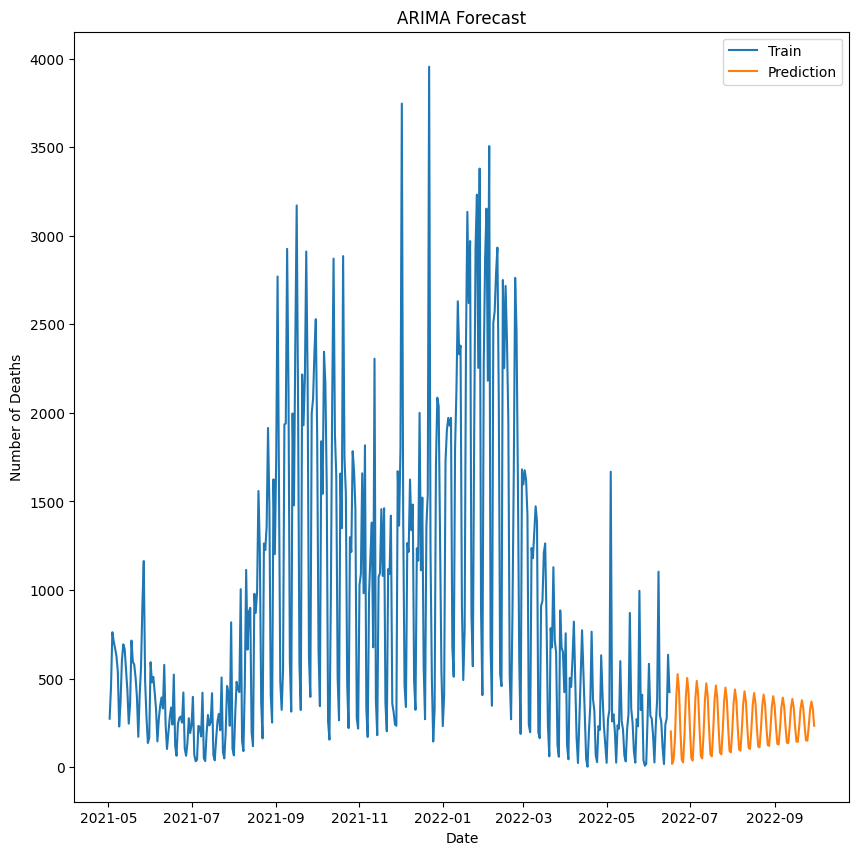

In [ ]:
#plot the predictions
plt.figure(figsize=(10,10))
plt.plot(train_data, label='Train')
plt.plot(forecast, label='Prediction')
plt.title("ARIMA Forecast")
plt.xlabel("Date")
plt.ylabel("Number of Deaths")
plt.legend()
plt.show()

### SARIMA Model

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Initialize and fit the SARIMA model
model = SARIMAX(train_data, order=(3, 1, 2), seasonal_order=(2, 0, 1, 7))
sarima_model = model.fit(disp=-1,freq='D')

# Make predictions on the test data
sarima_forecast = sarima_model.forecast(steps=num_days)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/optimizer.py:18: FutureWarning: Keyword arguments have been 

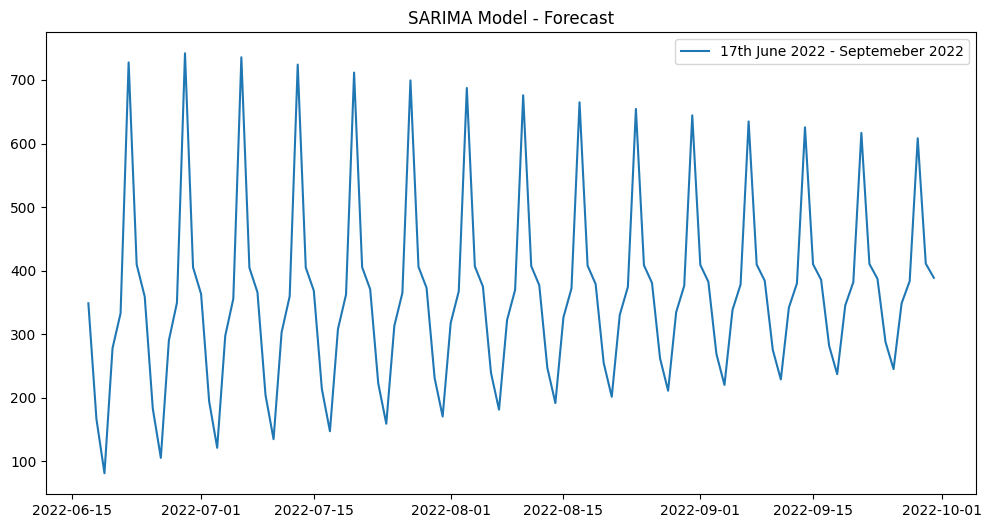

In [ ]:
# Plot the test data and the predicted values
plt.figure(figsize=(12, 6))
plt.plot(sarima_forecast, label='17th June 2022 - Septemeber 2022')
plt.title('SARIMA Model - Forecast')
plt.legend()
plt.show()

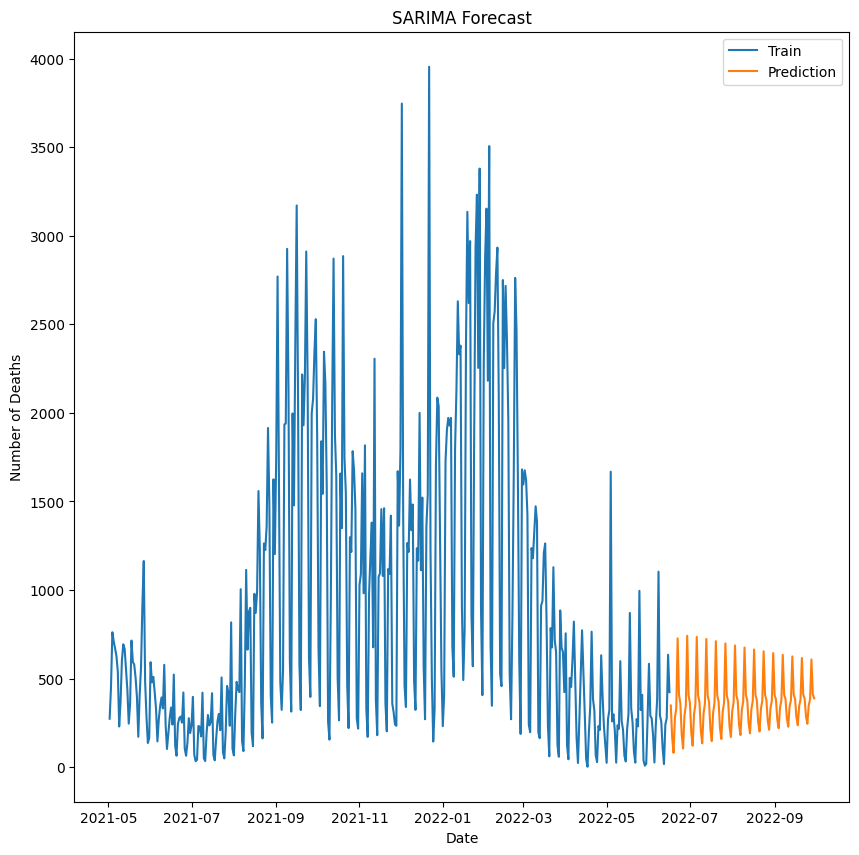

In [ ]:
#plot the predictions
plt.figure(figsize=(10,10))
plt.plot(train_data, label='Train')
plt.plot(sarima_forecast, label='Prediction')
plt.title("SARIMA Forecast")
plt.xlabel("Date")
plt.ylabel("Number of Deaths")
plt.legend()
plt.show()

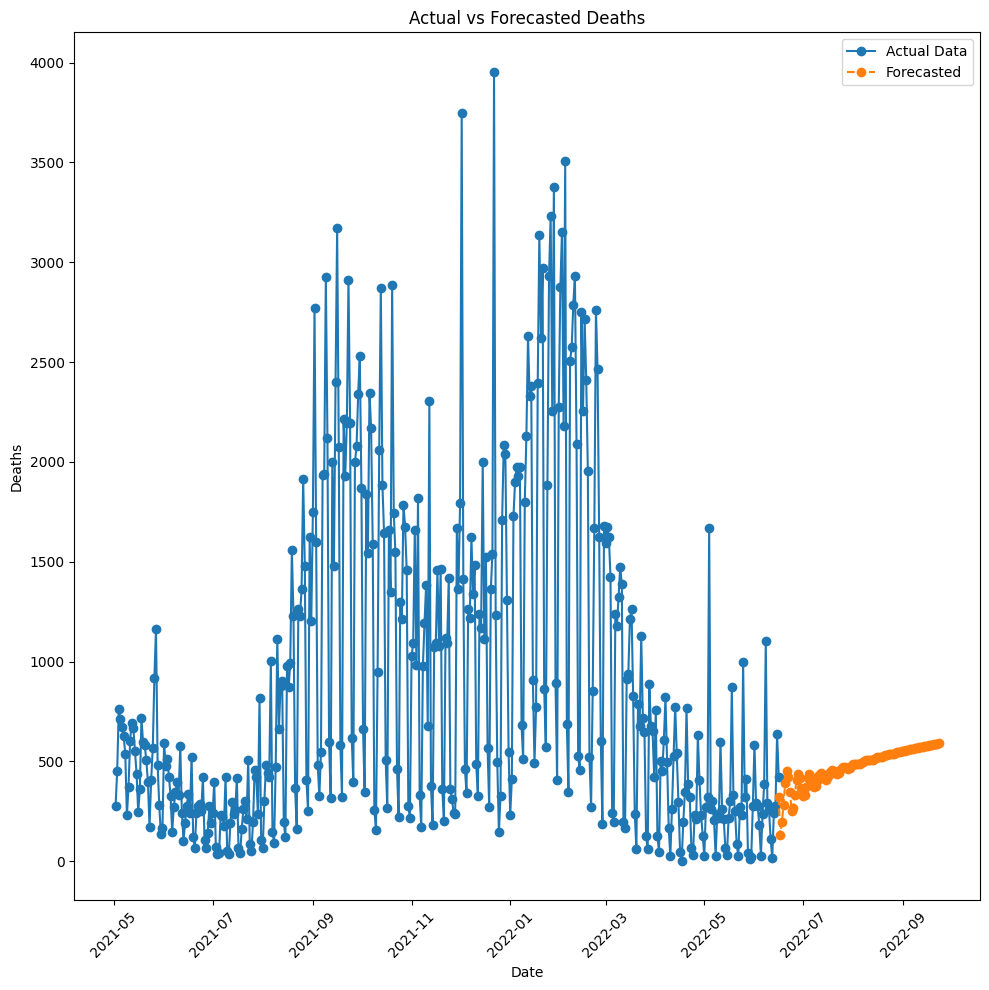

In [ ]:
# Plotting the entire dataset
plt.figure(figsize=(10, 10))
plt.plot(df.index, df['Deaths'], label='Actual Data', marker='o', linestyle='-')

# Plotting the forecasted values
plt.plot(predicted_df.index, predicted_df['Predicted_Deaths'], label='Forecasted', marker='o', linestyle='--')

plt.title('Actual vs Forecasted Deaths')
plt.xlabel('Date')
plt.ylabel('Deaths')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

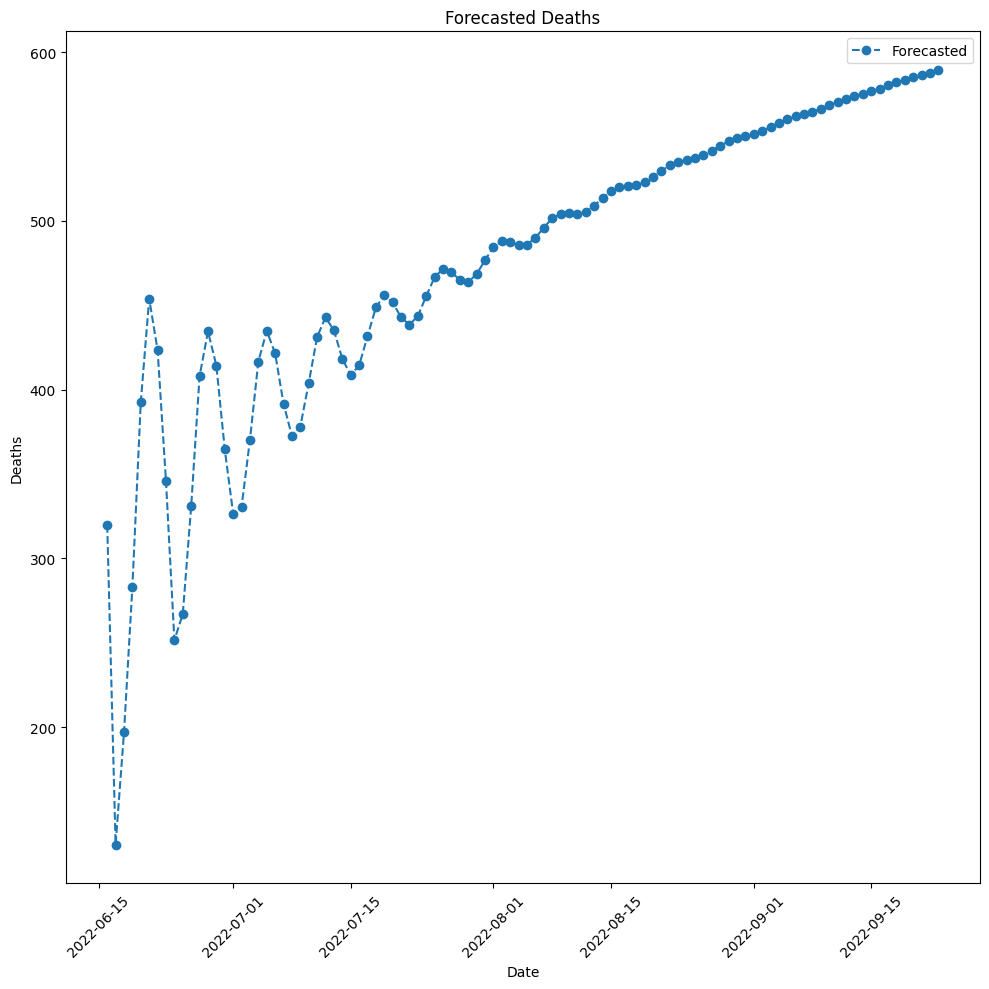

In [ ]:
# Plotting the entire dataset
plt.figure(figsize=(10, 10))

# Plotting the forecasted values
plt.plot(predicted_df.index, predicted_df['Predicted_Deaths'], label='Forecasted', marker='o', linestyle='--')

plt.title('Forecasted Deaths')
plt.xlabel('Date')
plt.ylabel('Deaths')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- As expected, the LSTM model forecasting does not make sense.

# ***Assessing Model Drift***

- Here, we are checking the possibility of model drift.

## Train and Test Split

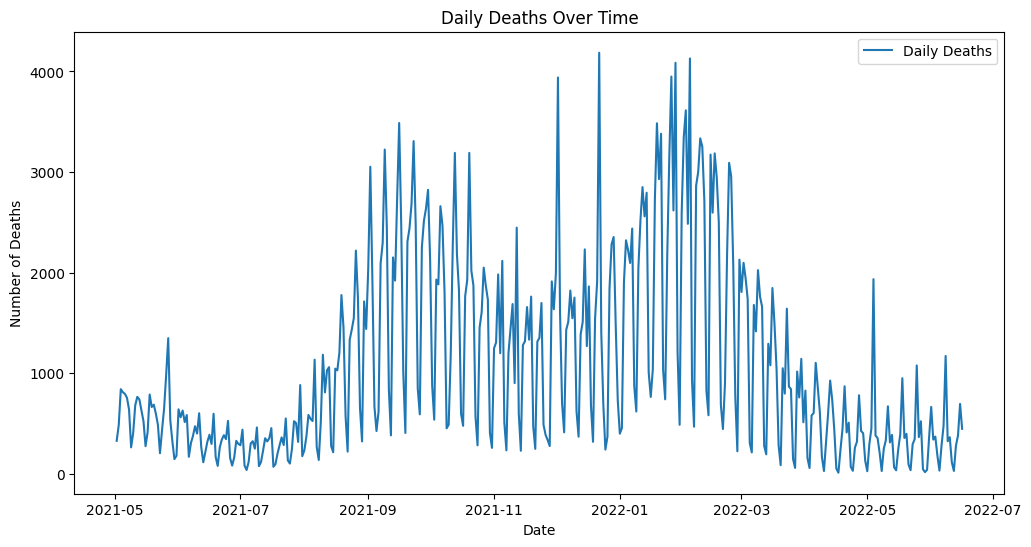

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(deaths_df, label='Daily Deaths')
plt.title('Daily Deaths Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Deaths')
plt.legend()
plt.show()

- The data exhibits no discernible trend or seasonality, displaying evolving patterns over time. This variability suggests a potential risk of model drift.
- Continuous monitoring of RMSE (Root Mean Square Error) following model creation is essential.
- Additionally, regularly updating the training data with new observations is advisable to mitigate this drift. Let's substantiate these points below.

## Checking the possibility of model drift

In [ ]:
# Splitting the data into train and test data
train_end = pd.to_datetime('2022-02-28')
train_data = deaths_df[deaths_df.index <= train_end]
test_data = deaths_df[deaths_df.index > train_end]

In [ ]:
test_data

Deaths
Date              
2022-03-01    1809
2022-03-02    2099
2022-03-03    1945
2022-03-04    1739
2022-03-05     310
...            ...
2022-06-12      31
2022-06-13     281
2022-06-14     384
2022-06-15     697
2022-06-16     449

[108 rows x 1 columns]

## ARIMA Model

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:62: UserWarning:

m (7) set for non-seasonal fit. Setting to 0



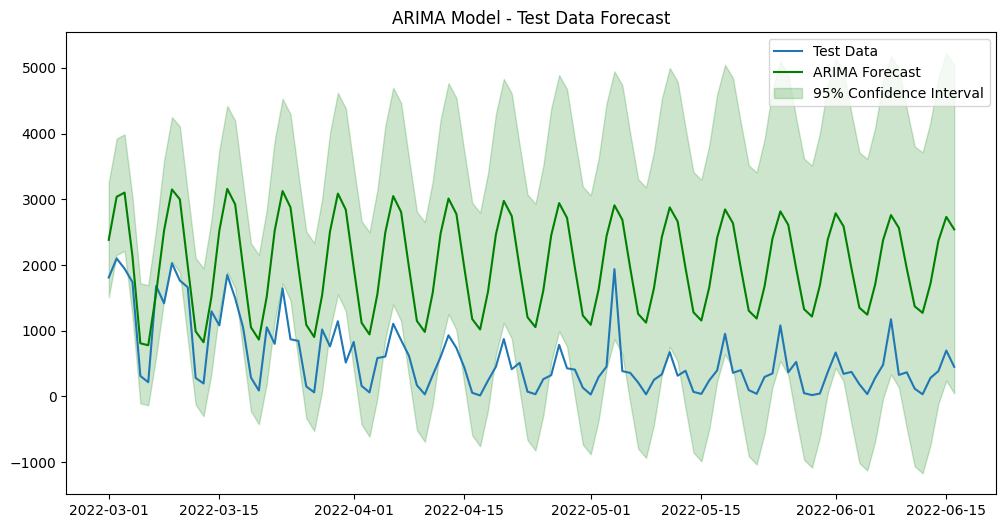

In [ ]:
# Use auto_arima to find the best ARIMA model
arima_model = auto_arima(train_data, suppress_warnings=True, seasonal=False, m=7)

arima_model.fit(train_data)

forecast, conf_int = arima_model.predict(n_periods=len(test_data), return_conf_int = True)
#conf_int = arima_model.forecast(steps=len(test_data)).conf_int()

plt.figure(figsize=(12, 6))
plt.plot(test_data, label='Test Data')
plt.plot(forecast, color='green', label='ARIMA Forecast')
plt.fill_between(test_data.index, conf_int[:, 0], conf_int[:, 1], color='green', alpha=0.2, label='95% Confidence Interval')
plt.title('ARIMA Model - Test Data Forecast')
plt.legend()
plt.show()

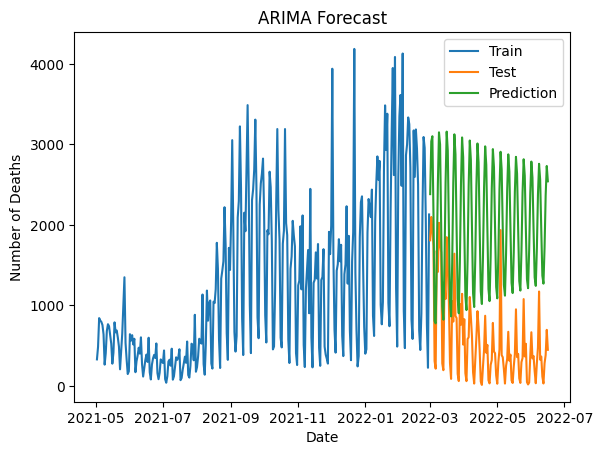

In [ ]:
#plot the predictions for validation set
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(forecast, label='Prediction')
plt.title("ARIMA Forecast")
plt.xlabel("Date")
plt.ylabel("Number of Deaths")
plt.legend()
plt.show()

- Previously, training the model with data up to June 30, 2022, led to predictions closely aligning with the actual test data. This was influenced by a pattern shift that began around March 2022(which was included in train data) and persisted throughout the test data.

- When the model was trained using data only up to February 2022, it missed capturing the new patterns or changes that emerged after that timeframe. Consequently, during testing with data exhibiting a different pattern post-February 2022, the model couldn't adjust. As a result, its predictions mirrored the patterns present in the training data, failing to adapt to the evolving trends seen in the test data.

- This emphasizes the significance of using current and relevant training data, particularly in time series forecasting where patterns can shift over time. Incorporating recent data helps the model learn from the most up-to-date patterns and enhances its ability to adapt to changes, as evidenced in the earlier case where training data included information up to June 30, 2022.

In [ ]:
rmse = sqrt(mean_squared_error(test_data,forecast))
print("RMSE: ",round(rmse,2))

mae = mean_absolute_error(test_data, forecast)
print(f"Mean Absolute Error: {mae:.4f}")

RMSE:  1527.29
Mean Absolute Error: 1426.9825
